In [26]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from scipy.signal import resample
import torch
import os
import math
import random
import shutil
import re
from sklearn.manifold import TSNE
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import itertools
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Concatenate, GlobalMaxPool1D, UpSampling1D, Reshape, ReLU, Add
from tensorflow.keras import Model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras import backend as K
import pandas as pd

The MobiAct dataset is composed of data that can be divided into three main categories:

1. **Activities of daily living (ADLs)**
2. **Falls**: Four types of falling patterns
3. **Scenarios**: Scenarios of leaving the home (SLH), composed of different ADLs

The SimCLR model built for this project will focus on the classification of ADLs activities. The scenarios and falls will thus be ignored.

These are the activities that will be used for classification, listed in the same order used in the classification process:

- **ADLs**:

  0. STD: Standing
  1. WAL: Walking  
  2. JOG: Jogging   
  3. JUM: Jumping   
  4. STU: Stairs up   
  5. STN: Stairs down   
  6. SCH: Stand to sit (sit on chair) 
  7. SIT: Sitting on chair  
  8. CHU: Sit to stand (chair up)  
  9. CSI: Car-step in      
  10. CSO: Car-step out            
  11. LYI: Lying 

Here are the three papers that inspired this project:

1. [Exploring Contrastive Learning in Human Activity Recognition for Healthcare](#)
2. [Study on Temperature (τ) Variation for SimCLR-based Activity Recognition](#)
3. [Contrastive Self-Supervised Learning for Sensor-based Human Activity Recognition](#)

In [6]:
# Paths 

# Path to the dataset
MobiAct_path = r"C:\progetto AMI\MobiAct_Dataset_v2.0"
# Path to the annotated data folder of the dataset
annotatedData_path = MobiAct_path + r"\Annotated Data"
# Path to the sampled data folder
sampledData_path = MobiAct_path + r"\Sampled_Data"

#path to the train_test_split folder
train_test_path = MobiAct_path + r"\train_test_split"
# Path to the train folder
train_path = train_test_path + r"\train"
# Path to the test folder
test_path = train_test_path + r"\testing"

# Path to the models folder
models_path = r"C:\progetto AMI\simclr_models"

## Data sampling & Train - Test splits creation

The `DatasetProcessor` class will be used to process and downsample the dataset.

The scenarios will be ignored, while the falls will be used to collect LYI data but will be ignored in the classification task.

The columns 'rel_time', 'azimuth', 'pitch', and 'roll' will be ignored, as the presence of this data made the model less accurate.

In [7]:
# labels of the ignored scenarios
IGNORED_LABELS = {
    'SLH', 'SBW', 'SLW', 'SBE', 'SRH'
}

LABELS_DICT = {
    'STD': 0,
    'WAL': 1,
    'JOG': 2,
    'JUM': 3,
    'STU': 4,
    'STN': 5,
    'SCH': 6,
    'SIT': 7,
    'CHU': 8,
    'CSI': 9,
    'CSO': 10,
    'LYI': 11,
    # these labels will be used to collect LYI data but will be ignored in the classification task
    'FOL': -1, 
    'FKL': -1,
    'BSC': -1,
    'SDL': -1,
}

# List of classes used in the classification task
classes = ['STD', 'WAL', 'JOG', 'JUM', 'STU', 'STN', 'SCH', 'SIT', 'CHU', 'CSI', 'CSO', 'LYI']

IGNORED_COLUMNS = ['rel_time', 'azimuth', 'pitch', 'roll']

# Reverse the LABELS_DICT to create a dictionary mapping integers to labels
REVERSED_LABELS_DICT = {v: k for k, v in LABELS_DICT.items()}

# Retrieve the label corresponding to the given integer value.
def get_label_from_int(integer_value):
    return REVERSED_LABELS_DICT.get(integer_value, "Unknown label")


class MobiActProcessor():
    def __init__(self, data_path, frequency):  
        self.data_path = data_path
        self.frequency = frequency
        self.files_dict = self.create_files_dict()

    # Function that gets the data files for each subject and experiment and stores them in a dictionary
    def create_files_dict(self):
        files_dict = {}
        for activity in os.listdir(self.data_path): 
            act_path = os.path.join(self.data_path, activity)
            for file in os.listdir(act_path): 
                subject_idx = int(file.split('_')[1])
                experiment_idx = int(file.split('_')[2])
                files_dict.setdefault(subject_idx, {}).setdefault(experiment_idx, []) 
                # Add the file to the dictionary for the corresponding subject and experiment    
                files_dict[subject_idx][experiment_idx].append(os.path.join(act_path, file))
        return files_dict

    # Function that retrieves the files for a given subject, experiment and activity from the dictionary
    def get_files(self, subject, experiment, activity):
        file = [file for file in self.files_dict[subject][experiment] if activity in file] 
        return next(iter(file), None)
    
    # Function that reads the data from a given file and returns the data and labels
    def get_data_labels(self, data_path):
        pd.set_option('future.no_silent_downcasting', True)
        data = pd.read_csv(data_path)
        labels = pd.DataFrame(data['label'].replace(LABELS_DICT))
        # data will be the df without the ignored columns and the label column
        data = data.drop(columns=IGNORED_COLUMNS + ['label'], axis=1)
        return data, labels

    # Function that creates a label_df with the start and end timestamps for each label
    def create_labels_df(self, data, labels):
        # Concatenate data and labels, keeping only the 'timestamp' and 'label' columns
        label_timestamp = pd.concat([data['timestamp'], labels], axis=1)

        # The cumulative sum creates a series of boolean values that are True when the label changes
        label_changes = (label_timestamp.label != label_timestamp.label.shift()).cumsum()
        # Group the data by the label changes
        grouped = label_timestamp.groupby(label_changes)

        # Concatenate min and max timestamps and the label for each group 
        lab_df = pd.concat([grouped.min()['timestamp'], grouped.max()['timestamp'], grouped.first()['label']], axis=1)
        lab_df.columns = ['start_timestamp', 'end_timestamp', 'label']
        # Return the labels dataframe
        return lab_df.reset_index(drop=True)
    
    # Function that downsamples the DataFrame, the sample duration is assumed to be expressed in seconds
    def downsample_dataframe(self, df, downsample_freq, sample_duration):
        n_samples = int(downsample_freq * sample_duration)
        downsampled_data = resample(df.values, n_samples)
        return pd.DataFrame(downsampled_data, columns=df.columns)

    # Function that given a DataFrame and the label_df, creates samples of the data
    def sample_dataframe(self, data, labels_df, sample_duration, overlap, downsampling_freq=None):
        samples_list = []
        num_samples = int(self.frequency * sample_duration) # Compute the number of samples for the specified duration
        half_window = num_samples // 2
        step = int(num_samples * (1 - overlap)) # Compute the step size for the sliding window
        df_copy = data.copy()

        # Iterate through each row in the label_df
        for _, label_row in labels_df.iterrows():
            current_label = label_row['label']
            
            if current_label != -1:
                # Find the start and end index for the current label
                start_idx = df_copy[df_copy['timestamp'] == label_row['start_timestamp']].index[0]
                end_idx = df_copy[df_copy['timestamp'] == label_row['end_timestamp']].index[0]
                # Adjust the start and end index to center the window around the label ensuring that the window is not out of bounds
                start_idx = max(start_idx - half_window, 0)   
                end_idx = min(end_idx + half_window, len(df_copy) - 1)  

                # Slide through the data segment to create samples
                while end_idx - start_idx >= num_samples:
                    current_end = start_idx + num_samples  
                    sample_df = df_copy.iloc[start_idx:current_end]  
                    # Downsample the sample if a downsampling frequency is specified
                    if downsampling_freq:
                        sample_df = self.downsample_dataframe(sample_df, downsampling_freq, sample_duration)

                    # Append the processed sample and its label to the list excluding the timestamp column
                    samples_list.append((sample_df.iloc[:, 1:], int(current_label)))
                    # Move the start index in order to maintain the overlap
                    start_idx += step
                        
        return samples_list
    
    def save_samples(self, destination, sample_duration, overlap, downsampling_freq=None):
        os.makedirs(destination, exist_ok=True) 
        # Get the subjects, experiments and activities
        subjects = set(self.files_dict.keys())
        experiments = set(exp for subject in subjects for exp in self.files_dict[subject].keys())
        activities = [act for act in os.listdir(self.data_path) if act not in IGNORED_LABELS]
        
        for subject in subjects:
            print(f"Processing subject: {subject}")  
            for experiment in experiments:
                if experiment not in self.files_dict[subject].keys():
                    continue                                                                                                        
                for activity in activities:
                    file = self.get_files(subject, experiment, activity) 
                    if not file:
                        continue
                    data, labels = self.get_data_labels(file) 
                    labels_df = self.create_labels_df(data, labels) 
                    sample_list = self.sample_dataframe(data, labels_df, sample_duration, overlap, downsampling_freq=downsampling_freq) 
                    
                    for trial, (sample_data, label) in enumerate(sample_list):
                        file_name = f"{subject}_{experiment}_{label}_{trial}.csv"
                        # Save the sample to the destination folder
                        sample_data.to_csv(os.path.join(destination, file_name), index=False) 

In [8]:
# block of code used to set the seed for reproducibility
def seed_all(seed):
	torch.manual_seed(seed)
	torch.cuda.manual_seed_all(seed)
	np.random.seed(seed)
	random.seed(seed)

This block of code is used to compute the frequency at which the MobiAct data has been sampled.

The data is taken from a random activity file in the dataset

In [9]:
sample_file = r"C:\progetto AMI\MobiAct_Dataset_v2.0\Annotated Data\JOG\JOG_1_1_annotated.csv"
data = pd.read_csv(sample_file)

# Extract the timestamp column and convert ns to s 
timestamps = data['timestamp'] / 1_000_000_000

# Compute differences between consecutive timestamps
time_diffs = timestamps.diff()

# Compute the sampling frequency
sampling_frequency = 1 / time_diffs.mean()
print(f"Sampling Frequency: {sampling_frequency} Hz")

Sampling Frequency: 199.59588567155814 Hz


Knowing that the sampling frequency is approximately 200 Hz, the raw signals are downsampled to 30 Hz and segmented into 50% overlapping 1-second windows. These segments are stored in the `Sampled_Data` folder with the format: `<SubjectID_ExperimentID_ActivityID_NoTrial>`.

Different downsampling frequencies have been tested, and 30 Hz is the best performing one. It effectively reduces noise from signals generated by activities linked to body movements, which typically have a low frequency.

In [10]:
mobiAct_freq = 200       # frequency of the MobiAct dataset
sample_dur = 1           # duration of the sample in seconds
overlapping = 0.5        # overlapping percentage
downsampling_freq = 30   # downsampling frequency

processor = MobiActProcessor(annotatedData_path, mobiAct_freq)
processor.save_samples(sampledData_path, sample_dur, overlapping, downsampling_freq)

Processing subject: 1
Processing subject: 2
Processing subject: 3
Processing subject: 4
Processing subject: 5
Processing subject: 6
Processing subject: 7
Processing subject: 8
Processing subject: 9
Processing subject: 10
Processing subject: 11
Processing subject: 12
Processing subject: 13
Processing subject: 14
Processing subject: 15
Processing subject: 16
Processing subject: 17
Processing subject: 18
Processing subject: 19
Processing subject: 20
Processing subject: 21
Processing subject: 22
Processing subject: 23
Processing subject: 24
Processing subject: 25
Processing subject: 26
Processing subject: 27
Processing subject: 28
Processing subject: 29
Processing subject: 30
Processing subject: 31
Processing subject: 32
Processing subject: 33
Processing subject: 34
Processing subject: 35
Processing subject: 36
Processing subject: 37
Processing subject: 38
Processing subject: 39
Processing subject: 40
Processing subject: 41
Processing subject: 42
Processing subject: 43
Processing subject: 

Dividing the `Sampled_Data` dataframe into Train-Test splits

In [11]:
# function used to sort the subjects correctly by their id
def extract_number(subject):
    match = re.search(r'\d+', subject)
    return int(match.group()) if match else float('inf')

# function that uses the file paths to copy the files to the destination folder
def copy_files(file_paths, destination_path):
    for file in file_paths:
        shutil.copy(file, destination_path)

# this function is used to split the subjects randomly into training and testing subjects
# the test_proportion parameter is used to specify the proportion of subjects that will be used for testing
def split_subjects(subjects, test_proportion):
    n_subjects = len(subjects)
    n_test_subjects = math.ceil(n_subjects * test_proportion)
    
    test_subjects = random.sample(subjects, n_test_subjects) 
    test_subjects = sorted(test_subjects, key=extract_number)
    train_subjects = [subject for subject in subjects if subject not in test_subjects]
    train_subjects = sorted(train_subjects, key=extract_number)

    print("Training subjects", train_subjects)
    print("Test subjects", test_subjects)
    return train_subjects, test_subjects

# this function splits the data into training and testing sets, creating a folder for each split if it does not exist
def train_test_data(data_path, destination_path, files, test_users):
    # path to the training and testing folders
    train_path = os.path.join(destination_path, "train")
    test_path = os.path.join(destination_path, "testing")

    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    test_files = [file for file in files if file.split('_')[0] in test_users]
    test_files_paths = [os.path.join(data_path, file) for file in test_files]
    train_files_paths = [os.path.join(data_path, file) for file in files if file not in test_files]

    print('Copying train split..')
    copy_files(train_files_paths, train_path)

    print('Copying test split..')
    copy_files(test_files_paths, test_path)

In [33]:
seed = 42  # seed for reproducibility
test_proportion = 0.2 # proportion of test subjects
seed_all(seed)
files = os.listdir(sampledData_path)

subjects = set([file.split('_')[0] for file in files if file not in ['train', 'test']])
sorted_subjects = sorted(subjects, key=extract_number)
_, test_users = split_subjects(sorted_subjects, test_proportion)
train_test_data(sampledData_path, train_test_path, files, test_users)

Training subjects ['1', '2', '3', '5', '8', '10', '11', '12', '13', '14', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '29', '30', '31', '33', '34', '37', '39', '40', '41', '42', '43', '45', '46', '47', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '62', '63', '64', '65', '66']
Test subjects ['4', '6', '7', '9', '15', '28', '32', '35', '36', '38', '44', '48', '61', '67']
Copying train split..
Copying test split..


## Data normalization

The mean and standard deviation are computed on the training dataset. These values are then used to normalize the train-test splits.

Normalizing the test data using the mean and standard deviation computed from the training set can be beneficial for several reasons:

- **Consistency**: It ensures that the test data is scaled in the same way as the training data. Consistency is crucial since the model was trained on data that was normalized using the training set statistics.

- **Avoiding Data Leakage**: Using the mean and standard deviation of the test set would introduce information from these sets into the training process, which is a form of data leakage. This can lead to overly optimistic performance estimates and poor generalization to new data.

- **Model Performance**: Many machine learning algorithms assume that the input features are centered around zero and have a similar scale. Normalizing the test data using the training set statistics helps meet these assumptions, leading to better model performance.

- **Fair Evaluation**: It ensures that the evaluation metrics on the test set are fair and comparable to the training process. This helps in accurately assessing the model's performance.

In [12]:
# function used to compute the means of the data given a list of files
def compute_means(files):
    cols = pd.read_csv(files[0]).shape[1]
    # Initialize the means array
    means = np.zeros(cols)
    for file in files:
        tmp_df = pd.read_csv(file)
        means += tmp_df.mean()
    means = means / len(files)
    return means

# function used to compute the standard deviations of the data given a list of files and the means
def compute_stdevs(files, means):
    df_shape = pd.read_csv(files[0]).shape
    # Initialize the variances array
    variances = np.zeros(df_shape[1])
    # number of samples
    n_sample = (len(files) * df_shape[0] - 1)  
    for file in files:
        tmp_df = pd.read_csv(file)
        variances += ((tmp_df - means) ** 2).sum()
    # Compute the standard deviations
    stdDevs = np.sqrt(variances / n_sample)
    return stdDevs

# function used to normalize the data given a list of files, the means and the standard deviations
def normalize(files, means, stdDevs):
    for file in files:
        tmp_df = pd.read_csv(file)
        tmp_df = (tmp_df - means) / stdDevs
        tmp_df.to_csv(file, index=None)

# function used to normalize train and test data w.r.t. the means and standard deviations 
# computed from the train data
def normalizeAll(train_path, test_path):    
    train_files = [os.path.join(train_path, file) for file in os.listdir(train_path)]
    test_files = [os.path.join(test_path, file) for file in os.listdir(test_path)]
    
    print('Computing Means from train data...')
    means = compute_means(train_files)
    
    print('Computing Std Devs from train data...')
    stds = compute_stdevs(train_files, means)

    print('Normalizing train data...')
    normalize(train_files, means, stds)
    
    print('Normalizing test data...')
    normalize(test_files, means, stds)

In [35]:
normalizeAll(train_path, test_path)

Computing Means from train data...
Computing Std Devs from train data...
Normalizing train data...
Normalizing test data...


## Transformations and Transformation Function

Here is the list of transformations implemented for SimCLR data augmentation. These transformations are taken from the paper: [1] https://arxiv.org/pdf/2011.11542

1. **Adding random Gaussian noise**: Random noise signals with a mean of zero and a standard deviation of 0.05 are added to the data sample.

2. **Scaling by a random factor**: Each channel of the signal is scaled by a random factor drawn from a normal distribution with a mean of 1.0 and a standard deviation of 0.1.

3. **Applying a random 3D rotation**: A random axis in 3D and a random rotational angle are drawn from a uniform distribution, and the corresponding rotation is applied to the sample.

4. **Inverting the signals**: The values of the sample are multiplied by a factor of -1.

5. **Reversing the direction of time**: The entire window of the sample is flipped in the time direction.

6. **Randomly scrambling sections of the signal**: The signal is segmented into 4 different sections, and a random permutation is performed on the segments, which are then recombined.

7. **Stretching and warping the time-series**: A random cubic spline with 4 fixed points is generated, defining the deviation of the speed of time flow from normal. The signal is then stretched and warped according to the cubic spline.

8. **Shuffling the different channels**: The channels of the signals are randomly permuted.

The transformation function, after applying Gaussian noise to the data, will randomly select 2 transformations and apply them with a probability of 0.5 each, creating 2 different views of the same data sample.

In [13]:
# function that applies jittering to the data by adding gaussian noise
def add_gaussian_noise(data, std_dev = 0.05):
    noise = np.random.normal(0, std_dev, data.shape)
    return data + noise

# function that applies a random scaling to the data 
def scale_data(data, mean = 1.0, std_dev = 0.1):
    scale = np.random.normal(mean, std_dev, data.shape[2])
    scale = scale.reshape(1, 1, data.shape[2])
    return data * scale

# function that applies a random rotation to the data
def rotation_transform(data):
    rotated_data = np.zeros_like(data)
    
    # Define the rotation angles and axes
    angles = np.random.uniform(-np.pi, np.pi, size=(data.shape[2] // 3,))
    axes = np.random.randn(data.shape[2] // 3, 3)
    axes = axes / np.linalg.norm(axes, axis=1)[:, np.newaxis]
    
    def axis_angle_to_rotation_matrix_3d(axis, angle):
        # Compute the rotation matrix for a given axis and angle
        cos_angle = np.cos(angle)
        sin_angle = np.sin(angle)
        one_minus_cos = 1 - cos_angle
        x, y, z = axis
        return np.array([
            [cos_angle + x * x * one_minus_cos, x * y * one_minus_cos - z * sin_angle, x * z * one_minus_cos + y * sin_angle],
            [y * x * one_minus_cos + z * sin_angle, cos_angle + y * y * one_minus_cos, y * z * one_minus_cos - x * sin_angle],
            [z * x * one_minus_cos - y * sin_angle, z * y * one_minus_cos + x * sin_angle, cos_angle + z * z * one_minus_cos]
        ])
        
    batch_size = data.shape[0]
    
    for i in range(data.shape[2] // 3):
        start_col = i * 3
        end_col = start_col + 3
        
        # Compute the rotation matrix for the current axis and angle
        matrix = axis_angle_to_rotation_matrix_3d(axes[i], angles[i])
        
        # Apply the rotation to each time step for every sample in the batch
        for b in range(batch_size):
            subset = data[b, :, start_col:end_col]
            rotated_subset = np.dot(subset, matrix.T)
            rotated_data[b, :, start_col:end_col] = rotated_subset
    
    return rotated_data  

# function that invert the data along the y-axis 
def invert_data(data):
    return data * - 1

# function used to reverse the data along the time axis
def reverse_data(data):
    return np.flip(data, axis = 1)

# Function that applies a random permutation to the data by splitting it into 5 segments and shuffling them
# on the axis 1 and then concatenating them back
def random_permutation(data):
    num_segments = 5
    segments = np.split(data, num_segments, axis = 1)
    random.shuffle(segments)
    return np.concatenate(segments, axis = 1)

# Function that applies a random time warping to the data according 
# to a random cubic spline with 4 fixed points
def stretching_warping(data):
    num_points = 4  # Number of fixed points
    batch_size = data.shape[0]
    time_steps = data.shape[1]
    warped_data = np.zeros_like(data)
    
    fixed_points = np.linspace(0, time_steps - 1, num_points)
    
    for b in range(batch_size):
        # Generate random offsets for each batch
        random_offsets = np.random.uniform(low=-1, high=1, size=(num_points))
        fixed_points_with_offsets = fixed_points + random_offsets
        fixed_points_with_offsets = np.clip(fixed_points_with_offsets, 0, time_steps - 1)
        x = np.arange(time_steps)
        
        for i in range(data.shape[2]):  # Loop over each feature
            spline = np.interp(x, fixed_points, fixed_points_with_offsets)
            warped_data[b, :, i] = np.interp(spline, x, data[b, :, i])
    
    return warped_data

# Function that shuffles the channels of the data
def shuffle_channels(data):
    n_channels = data.shape[2]
    channels = np.split(data, n_channels, axis = 2)
    random.shuffle(channels)
    return np.concatenate(channels, axis = 2)

# Function that applies gaussian noise to the data by default
# and applies two random transformations from the transformations_set each with 0.5 probability
def apply_random_transformations(data, transformations_set):
    applied_trans = [add_gaussian_noise, add_gaussian_noise]
    # apply gaussian noise to the data by default
    transformed_data_1 = add_gaussian_noise(data)
    transformed_data_2 = add_gaussian_noise(data)
    # if there is only one transformation in the set, duplicate it
    if len(transformations_set) == 1:
        transformations_set = transformations_set * 2
    # shuffle the transformations set and select the first two transformations
    random.shuffle(transformations_set)
    selected_transformations = transformations_set[:2]
    
    if np.random.rand() < 0.5: 
        transformed_data_1 = selected_transformations[0](data)
        applied_trans[0] = selected_transformations[0]
        
    if np.random.rand() < 0.5:
        transformed_data_2 = selected_transformations[1](data)
        applied_trans[1] = selected_transformations[1]
        
    return transformed_data_1, transformed_data_2, applied_trans

Visualization of how the apply_random_transformations function operates


Text(0.5, 1.0, 'Transformed Data 2 (add_gaussian_noise transformation)')

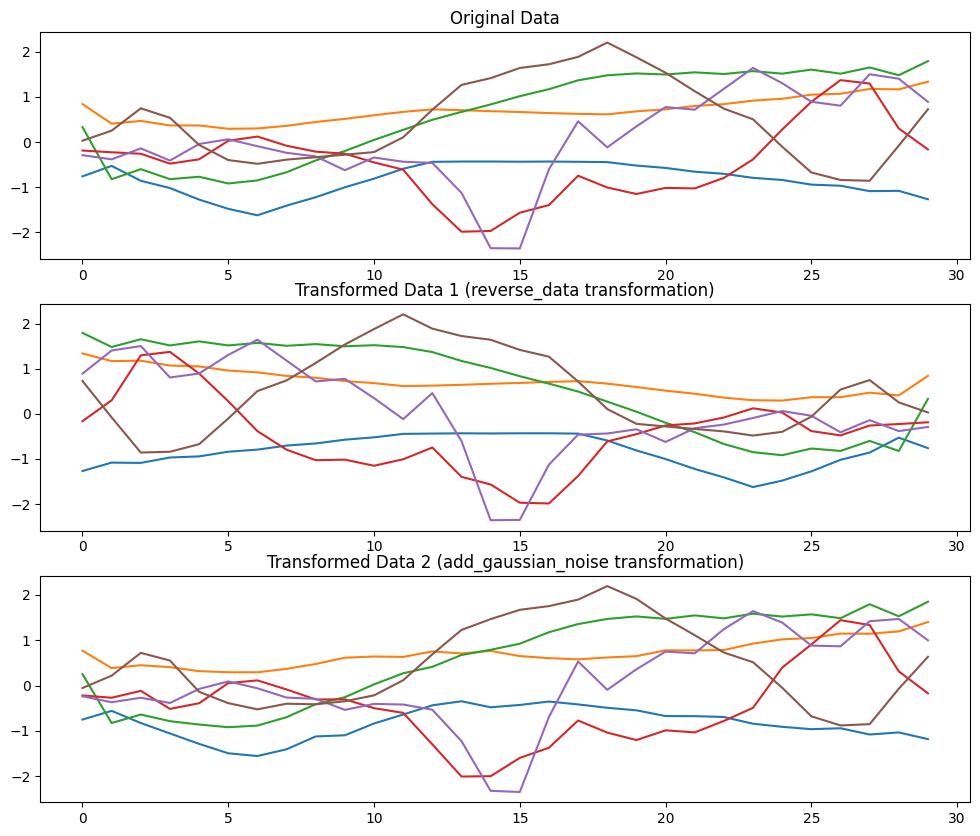

In [16]:
# test the apply_random_transformations function
exampleData_path = train_path + r"\1_1_0_0.csv" # path to an example data file
data = pd.read_csv(exampleData_path)
data = data.values
data = data.reshape(1,30,6)
transformations = [add_gaussian_noise, scale_data, rotation_transform, invert_data, reverse_data, random_permutation, stretching_warping, shuffle_channels]
transformed_data_1, transformed_data_2, transformations = apply_random_transformations(data, transformations)

fig, axs = plt.subplots(3, 1, figsize=(12, 10))
axs[0].plot(data[0,:,:])
axs[0].set_title('Original Data')
axs[1].plot(transformed_data_1[0,:,:])
axs[1].set_title('Transformed Data 1 ({} transformation)'.format(transformations[0].__name__))
axs[2].plot(transformed_data_2[0,:,:])
axs[2].set_title('Transformed Data 2 ({} transformation)'.format(transformations[1].__name__))

In [17]:
# function that plots the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=True, cmap=plt.cm.Blues, figsize=(22,8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=+++90, fontsize=11)
    plt.yticks(tick_marks, classes, fontsize=11)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black"
               )

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()
    plt.tick_params(axis="both", which="both", bottom=False, left=False)
    plt.grid(False)
    plt.box(False) #remove box
    return plt

## Baseline model evaluation 

The training dataset is divided into pretraining and finetuning splits.

For the pretraining process, the majority of the training data will be used, while for the finetuning task, only a small portion of the data will be used.

This is done to test the benefit of SimCLR self-supervised training in cases of data scarcity, as opposed to a supervised approach that will be used for the Baseline model.

### Class Weights

For the pretraining and finetuning tasks, a list of all the class weights is computed on the sets used to train the models. This is necessary because the dataset presents heavily imbalanced classes: some classes have thousands of samples, while other classes have considerably fewer samples.

Loading pre-training and fine-tuning data and labels

In [21]:
# Load the data from the train folder and create the train dataset
pre_train_data = []
fine_tuning_data = []

pre_train_labels = []
fine_tuning_labels = []

ohe_labels_pre_train = []
ohe_labels_fine_tuning = []

for file in os.listdir(train_path):  
    data = pd.read_csv(os.path.join(train_path, file)).values
    pre_train_data.append(data)  # pre-training data
    label = int(file.split('_')[2])
    ohe_label = np.zeros(len(classes))
    ohe_label[label] = 1
    ohe_labels_pre_train.append(ohe_label)  # pre-training one hot encoded labels
    pre_train_labels.append(label)  # pre-training labels
    
# Split the data into pre-training and fine-tuning data with the option stratify
pre_train_data, fine_tuning_data, pre_train_labels, fine_tuning_labels, ohe_labels_pre_train, ohe_labels_fine_tuning = train_test_split(pre_train_data, pre_train_labels, ohe_labels_pre_train, 
                                                                                                                                        test_size=0.025, random_state=42, stratify=pre_train_labels)
    
pre_train_data = np.array(pre_train_data)
pre_train_labels = np.array(pre_train_labels)
fine_tuning_data = np.array(fine_tuning_data)
fine_tuning_labels = np.array(fine_tuning_labels)   
 
print(pre_train_data.shape, pre_train_labels.shape, len(ohe_labels_pre_train))
print(fine_tuning_data.shape, fine_tuning_labels.shape, len(ohe_labels_fine_tuning))

(93218, 30, 6) (93218,) 93218
(2391, 30, 6) (2391,) 2391


Loading test data and labels

In [22]:
# load the test and validation folders and create the test and validation datasets
test_data = []
test_labels = []
ohe_test_labels = []

for file in os.listdir(test_path):
    data = pd.read_csv(os.path.join(test_path, file)).values
    test_data.append(data) 
    label = int(file.split('_')[2])
    test_labels.append(label)  
    ohe_label = np.zeros(len(classes))
    ohe_label[label] = 1
    ohe_test_labels.append(ohe_label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)       
print(test_data.shape, test_labels.shape, len(ohe_test_labels))

(25924, 30, 6) (25924,) 25924


### Baseline model

The baseline model is a simple classifier


In [18]:
def create_baseline_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs, name = 'baseline')

In [19]:
# print number of columns in the data
data = pd.read_csv(exampleData_path)
input_shape = (downsampling_freq, len(data.columns))
baseline = create_baseline_model(input_shape, num_classes=len(classes))

print(baseline.summary())

Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30, 128)        │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,444 (9.55 KB)

 Trainable params: 2,444 (9.55 KB)

 Non-trainable params: 0 (0.00 B)

None


In order to evaluate the Baseline model only a small subset of the finetuning data will be used for trainig, the remaining data will be used for validation

In [25]:
# create validation data as a subset of the fine-tuning data

baseline_data, baseline_validation_data, baseline_labels, baseline_val_labels, ohe_labels_baseline, ohe_validation_baseline = train_test_split(fine_tuning_data, fine_tuning_labels, ohe_labels_fine_tuning, test_size=0.1)
print(baseline_data.shape, baseline_validation_data.shape, baseline_labels.shape, baseline_val_labels.shape, len(ohe_labels_baseline), len(ohe_validation_baseline))

class_weights_baseline = compute_class_weight('balanced', classes=np.unique(baseline_labels), y=baseline_labels)
class_weights_dict_baseline = dict(enumerate(class_weights_baseline))
print(class_weights_dict_baseline)

(2151, 30, 6) (240, 30, 6) (2151,) (240,) 2151 240
{0: 0.26129737609329445, 1: 0.27920560747663553, 2: 0.9903314917127072, 3: 0.9637096774193549, 4: 1.7747524752475248, 5: 1.8868421052631579, 6: 6.894230769230769, 7: 2.0843023255813953, 8: 22.40625, 9: 3.8967391304347827, 10: 3.8138297872340425, 11: 3.8138297872340425}



Creating the model...

Training...
Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0506 - loss: 2.4043 - val_accuracy: 0.1083 - val_loss: 2.4505
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1073 - loss: 2.3711 - val_accuracy: 0.1500 - val_loss: 2.3733
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1314 - loss: 2.3430 - val_accuracy: 0.1625 - val_loss: 2.3140
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1598 - loss: 2.1905 - val_accuracy: 0.2542 - val_loss: 2.2496
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2545 - loss: 2.1094 - val_accuracy: 0.3000 - val_loss: 2.1926
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3150 - loss: 2.1342 - val_accuracy: 0.3375 - val_loss: 2.1337
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3535 - loss: 2.1972 - val_accuracy: 0.3500 - val_loss: 2.0763
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3790 - los

<module 'matplotlib.pyplot' from 'c:\\Users\\Riccardo Adorante\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

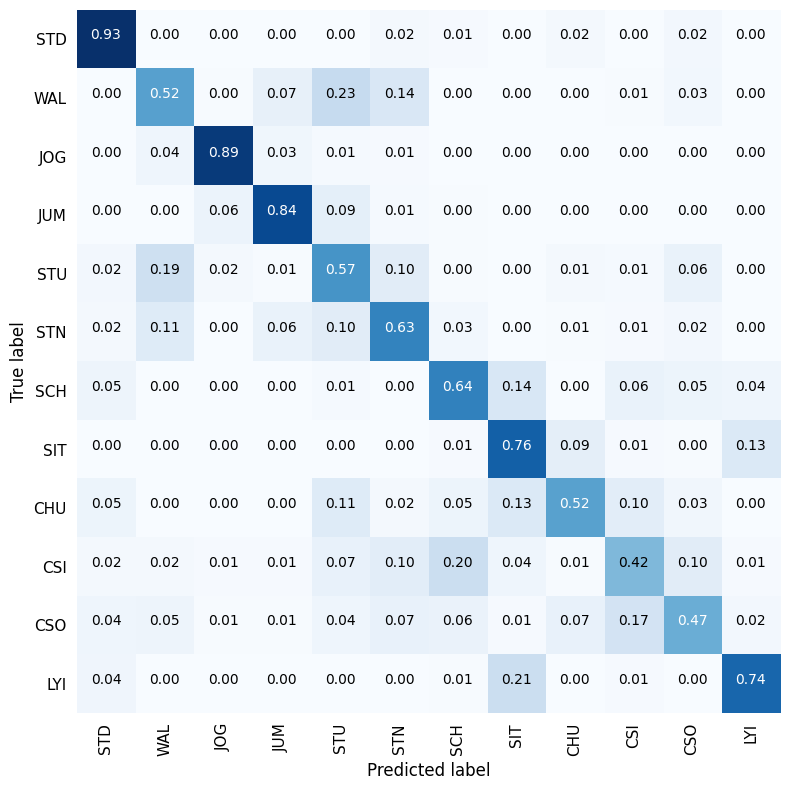

In [35]:
# early stopping: if for 5 consecutive epochs the loss on the validation set does not improve, we stop the training process and restore the weights of the best model
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

cm = [np.zeros([len(classes)]) for _ in range(len(classes))]

n_epochs = 200
batch_size = 128

ohe_labels_baseline = np.array(ohe_labels_baseline)
ohe_validation_baseline = np.array(ohe_validation_baseline)
ohe_test_labels = np.array(ohe_test_labels)

input_shape = baseline_data.shape[1:] 

print("\nCreating the model...")
model = create_baseline_model(input_shape, num_classes=len(classes))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

print("\nTraining...")
history = model.fit(x=baseline_data,
                  y=ohe_labels_baseline,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = (baseline_validation_data, ohe_validation_baseline),
                  class_weight=class_weights_dict_baseline,
                  callbacks=[early_stopping])

print("\nPredicting...")
y_preds = model.predict(test_data)
y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(ohe_test_labels, axis=1)

print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))

print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes[el])
for el in y_targets: s_targets.append(classes[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes)

## SIMCLR Model

The SIMCLR Model is composed by a transformer-encoder module and a Projection MLP head


Transformer - Encoder model structure



In [20]:
def create_transformer_encoder(input_shape):
    inputs = tf.keras.Input(shape=input_shape, name='input')

    x = Conv1D(32, 8, kernel_regularizer=tf.keras.regularizers.l2(l2=1e-4))(inputs)     
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)
    
    x = Conv1D(64, 4, kernel_regularizer=tf.keras.regularizers.l2(l2=1e-4))(x)         
    x = BatchNormalization()(x)
    x = LeakyReLU()(x) 
    x = Dropout(0.2)(x)

    x = Conv1D(96, 3, kernel_regularizer=tf.keras.regularizers.l2(l2=1e-4))(x)       
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)
    
    # Multi-head self-attention
    attention = MultiHeadAttention(num_heads=4, key_dim=24)(x, x)
    x = LayerNormalization(epsilon=1e-6)(x + attention)

    x = GlobalMaxPool1D(data_format='channels_last', name='global_max_pooling1d')(x)

    return Model(inputs, x, name="transformer_encoder")

Projection head & Prediction head model structures

In the second implementation of the projection head a residual connection is used:
- Residual connections can help preserve the features learned during pre-training and enable the model to reuse features from earlier layers,
which can be beneficial when finetuning a pretrained model.

In [22]:

def attach_projection_head(transformer_encoder):
    input = transformer_encoder.input
    x = transformer_encoder.output

    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)

    return Model(input, x, name="projection_head")


def attach_prediction_head(transformer_encoder, num_classes):
    input = transformer_encoder.input
    x = transformer_encoder.output[0]
    x = tf.keras.layers.Flatten()(x)
    
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    
    output = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=input, outputs=output, name="prediction_head")

def attach_prediction_head_v2(transformer_encoder, num_classes):
    input = transformer_encoder.input
    x = transformer_encoder.output[0]
    
    x = tf.keras.layers.Reshape((1, -1))(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # First dense block with residual connection
    residual = x
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.3)(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.3)(x)
    # shape of residual and x must be the same
    residual = Dense(512)(residual)
    x = Add()([x, residual])
    x = ReLU()(x)
    
    # Second dense block
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)   
    x = Dropout(0.3)(x)
    
    output = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=input, outputs=output, name="prediction_head_v2")

Model for pretrainig (Transformer - Encoder + Projection Head)

In [23]:
transformer_enc = create_transformer_encoder(input_shape)
pretraining_model = attach_projection_head(transformer_enc)

print(pretraining_model.summary())

Model: "projection_head"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 30, 6)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 23, 32)    │      1,568 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 23, 32)    │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 23, 32)    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 23, 32)    │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 20, 64)    │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 20, 64)    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 20, 64)    │          0 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 18, 96)    │     18,528 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 18, 96)    │        384 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 18, 96)    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 18, 96)    │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 18, 96)    │     37,248 │ dropout_2[0][0],  │
│ (MultiHeadAttentio… │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 18, 96)    │          0 │ dropout_2[0][0],  │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 18, 96)    │        192 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 96)        │          0 │ layer_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1024)      │     99,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1024)      │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1024)      │  1,049,600 │ dropout_4[0][0] 

 Total params: 1,215,488 (4.64 MB)

 Trainable params: 1,215,104 (4.64 MB)

 Non-trainable params: 384 (1.50 KB)

None


## Pretraining

Pretext task: During pretraining, the encoder-transformer module is attached to the projection head and trained in an unsupervised manner using the NT_Xent loss. This loss function trains the model to bring views of the same data closer in the feature space while pushing views of different data further apart.

A batch of signals is passed through the *apply_random_transformation* module, which generates two transformed views for each data sample. The transformer-encoder and projection head produce a representation vector \( Z_i \), which is later used for computing a similarity matrix and the loss.

In [30]:
def simclr_train_model(model, training_set, label_set, optimizer, batch_size, transformation_function,transformations_subset, class_weights, temperature=0.1, epochs=100, verbose=0):
    epoch_wise_loss = []

    for epoch in range(epochs):
        step_wise_loss = []

        # Randomly shuffle the dataset
        indices = np.arange(len(training_set))
        np.random.shuffle(indices)
        shuffled_dataset = training_set[indices]
        shuffled_labels = label_set[indices]

        # Training
        num_batches = math.ceil(len(training_set) / batch_size)

        for i in range(num_batches):
            data_batch = shuffled_dataset[i * batch_size : (i + 1) * batch_size]
            labels_batch = shuffled_labels[i * batch_size : (i + 1) * batch_size]
            
            # Apply transformation
            transform_1,transform_2, _ = transformation_function(data_batch, transformations_subset)
            
            # compute weights for the batch
            batch_weights = np.array([class_weights[label] for label in labels_batch])
            
            # Weighted forward propagation
            loss, gradients = get_NT_Xent_loss_gradients(model, transform_1, transform_2, normalize=True, temperature=temperature, weights=batch_weights)

            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))

        if verbose > 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return model, epoch_wise_loss

def get_NT_Xent_loss_gradients(model, samples_transform_1, samples_transform_2, normalize=True, temperature=1.0, weights=1.0):
    with tf.GradientTape() as tape:
        hidden_features_transform_1 = model(samples_transform_1)
        hidden_features_transform_2 = model(samples_transform_2)
        loss = NT_Xent_loss(hidden_features_transform_1, hidden_features_transform_2, normalize=normalize, temperature=temperature, weights=weights)

    gradients = tape.gradient(loss, model.trainable_variables)
    return loss, gradients

# this Python decorator allows increasing the performance
@tf.function
def NT_Xent_loss(hidden_features_transform_1, hidden_features_transform_2, normalize=True, temperature=1.0, weights=1.0):
    """
    The normalised temperature-scaled cross entropy loss function of SimCLR Contrastive training
    Reference: Chen, T., Kornblith, S., Norouzi, M., & Hinton, G. (2020). A simple framework for contrastive learning of visual representations. arXiv preprint arXiv:2002.05709.
    https://github.com/google-research/simclr/blob/master/objective.py
    Parameters:
        hidden_features_transform_1: the features (activations) extracted from the inputs after applying transformation 1 (e.g. model(transform_1(X)))
        hidden_features_transform_2: the features (activations) extracted from the inputs after applying transformation 2 (e.g. model(transform_2(X)))
        normalize = True: normalise the activations if true
        temperature: hyperparameter, the scaling factor of the logits. The authors found that an appropriate temperature parameter can help the model learn from negatives samples
        weights: weights of different samples
    """
    LARGE_NUM = 1e9

    h1 = hidden_features_transform_1
    h2 = hidden_features_transform_2
    if normalize:
        h1 = tf.math.l2_normalize(h1, axis=1)
        h2 = tf.math.l2_normalize(h2, axis=1)

    batch_size = tf.shape(hidden_features_transform_1)[0]
    masks = tf.one_hot(tf.range(batch_size), batch_size)   # this is an identity matrix of size batch_size [[1, 0, 0, ...], [0, 1, 0, ...], [0, 0, 1, ...]]

    # here we get the cosine distance (i.e., similarity) between samples transformed with the first transformation
    # in the result, the value at [i][j] is the cosine distance between i-th and j-th embeddings in the input matrix
    # note that above we normalized the hidden features, so the cosine similarity can be obtained through the dot product, without any further normalization of the vectors
    # logits_h1h1 will be something like
    # [[sim(X_h1, X_h1), sim(X_h1, Y_h1), sim(X_h1, Z_h1), ...],
    #  [sim(Y_h1, X_h1), sim(Y_h1, Y_h1), sim(Y_h1, Z_h1), ...],
    #  ...]
    # where X, Y, Z, ... are unlabeled samples from the training set, and
    # X_h1 is, for instance, the embeddings obtained by the model on the sample X transformed with the first transformation
    logits_h1h1 = tf.matmul(h1, h1, transpose_b=True) / temperature
    logits_h1h1 = logits_h1h1 - masks * LARGE_NUM   # suppress the similarity between each transformed sample with itself, because we don't want to maximize this similarity. Here, we give a very low value to this similarity, so that it is already "minimized" during the training process

    # here we get the cosine distance (i.e., similarity) between samples transformed with the second transformation
    logits_h2h2 = tf.matmul(h2, h2, transpose_b=True) / temperature
    logits_h2h2 = logits_h2h2 - masks * LARGE_NUM   # suppress the similarity between each transformed sample with itself, because we don't want to maximize this similarity. Here, we give a very low value to this similarity, so that it is already "minimized" during the training process

    # here we get the cosine distance (i.e., similarity) between the samples transformed with the first transformation and transformed with the second transformation
    # note that, we will maximize the similarities on the diagonal of this matrix!
    # logits_h1h2 will be something like
    # [[sim(X_h1, X_h2), sim(X_h1, Y_h2), sim(X_h1, Z_h2), ...],
    #  [sim(Y_h1, X_h2), sim(Y_h1, Y_h2), sim(Y_h1, Z_h2), ...],
    #  ...]
    logits_h1h2 = tf.matmul(h1, h2, transpose_b=True) / temperature

    # here we get the cosine distance (i.e., similarity) between the samples transformed with the second transformation and transformed with the first transformation
    # note that, we will maximize the similarities on the diagonal of this matrix!
    logits_h2h1 = tf.matmul(h2, h1, transpose_b=True) / temperature

    # from_logits=True can be used when the output of the machine learning model is not a probabiity distribution
    # Sparse because the labels will be provided as integers and not in a one-hot-encoded format
    entropy_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    labels = tf.range(batch_size)   # labels will be [0, 1, ..., batch_size-1], hence, they are provided as integers

    # Typically, SparseCrossEntropy works like this:
    # labels = [0, 1, 0, ...]
    # classifier_predictions = [[0.95, 0.05, 0], [0, 0.80, 0.20], [0.99, 0, 0.01], ...]
    # example: in the first prediction, the label is 0, hence, the model will try to maximize
    #          the probability value of the probability distribution that is at index 0

    # In this implementation, the maximum similarity must correspond to value at the index encoded by the label
    # labels = [0, 1, 2, ...]
    # similarities = [sim(X_h1,X_h2), sim(X_h1, Y_h2), sim(X_h1, Z_h2), ...<other elements of logits_h1h2>..., sim(X_h1, X_h1), sim(X_h1, Y_h1), ...<other elements of logits_h1h1>...],
    #                [sim(Y_h1,X_h2), sim(Y_h1, Y_h2), sim(Y_h1, Z_h2), ...],
    #                ...
    # Hence, for the first row, the model will try to maximize the similarity at index 0, that is sim(X_h1, X_h2) and to minimize all the other similarities in the row
    # For the second row, the model will try to maximize the similarity ad index 1, that is sim(Y_h1, Y_h2) and to minimize all the other similarities in the row
    loss_a = entropy_function(labels, tf.concat([logits_h1h2, logits_h1h1], 1), sample_weight=weights)

    # We can also consider the inverted case
    # labels = [0, 1, 2, ...]
    # similarities = [sim(X_h2,X_h1), sim(X_h2, Y_h1), sim(X_h2, Z_h1), ...<other elements of logits_h2h1>..., sim(X_h2, X_h2), sim(X_h2, Y_h2), ...<other elements of logits_h2h2>...],
    #                [sim(Y_h2,X_h1), sim(Y_h2, Y_h1), sim(Y_h2, Z_h1), ...],
    #                ...
    loss_b = entropy_function(labels, tf.concat([logits_h2h1, logits_h2h2], 1), sample_weight=weights)

    # the final loss will be the simple sum of the two previous ones
    loss = loss_a + loss_b

    return loss

The data and class_weights that will be used for pre-training

In [31]:
print(pre_train_data.shape, pre_train_labels.shape, len(ohe_labels_pre_train))

#compute the class weights for the pre-training set
class_weights_preTrain = compute_class_weight('balanced', classes=np.unique(pre_train_labels), y=pre_train_labels)
class_weights_dict_preTrain = dict(enumerate(class_weights_preTrain))
class_weights_tensor = tf.constant(list(class_weights_dict_preTrain.values()), dtype=tf.float32)
print(class_weights_tensor)

(93218, 30, 6) (93218,) 93218
tf.Tensor(
[ 0.2628821   0.27841893  0.9627174   0.9572602   1.7952777   1.9405862
  6.468082    2.1183984  22.006138    4.050139    3.79305     3.7600033 ], shape=(12,), dtype=float32)


In order to test how different combinations of transformations impacted the model's performances 3 transformations subsets will be used to pre-train different models

Subset1 is used to pre-train the model on all the available transformations

Subset2 and subset3 are taken from the paper : [1] https://arxiv.org/pdf/2011.11542 in order to see if they helped in improving model performances

At the end of the pre-training cycle 9 models will be created and stored in the models folder. 
Each model will be pre-trainded on the 3 different transformations subsets and with 3 different temperature(tau) values for the NT Xent loss.

From the pre-training report is possible to verify the loss values reached after 50 epochs by the models, it is worth noting how a higher temperature negatively impacts the loss value.
Even though in paper [2] the same tau value of 0.2 turned out to be the best performing one.

More precisely, small temperatures tend to increase the impact of hard negative samples, resulting in a larger gap between positive samples and other misleading negatives. This could explain why a smaller tau value is more beneficial in the classification task of this project, as many activities will be represented by very similar signals.

A too high temperature value could lead infact to misinterpretation of non-hard negatives.

Testing with tau (temperature) value: 0.05
Training model with transformations subset 1...
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2592 samples in 0.000s...
[t-SNE] Computed neighbors for 2592 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2592
[t-SNE] Computed conditional probabilities for sample 2000 / 2592
[t-SNE] Computed conditional probabilities for sample 2592 / 2592
[t-SNE] Mean sigma: 0.626188
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.647308
[t-SNE] KL divergence after 1000 iterations: 0.638445


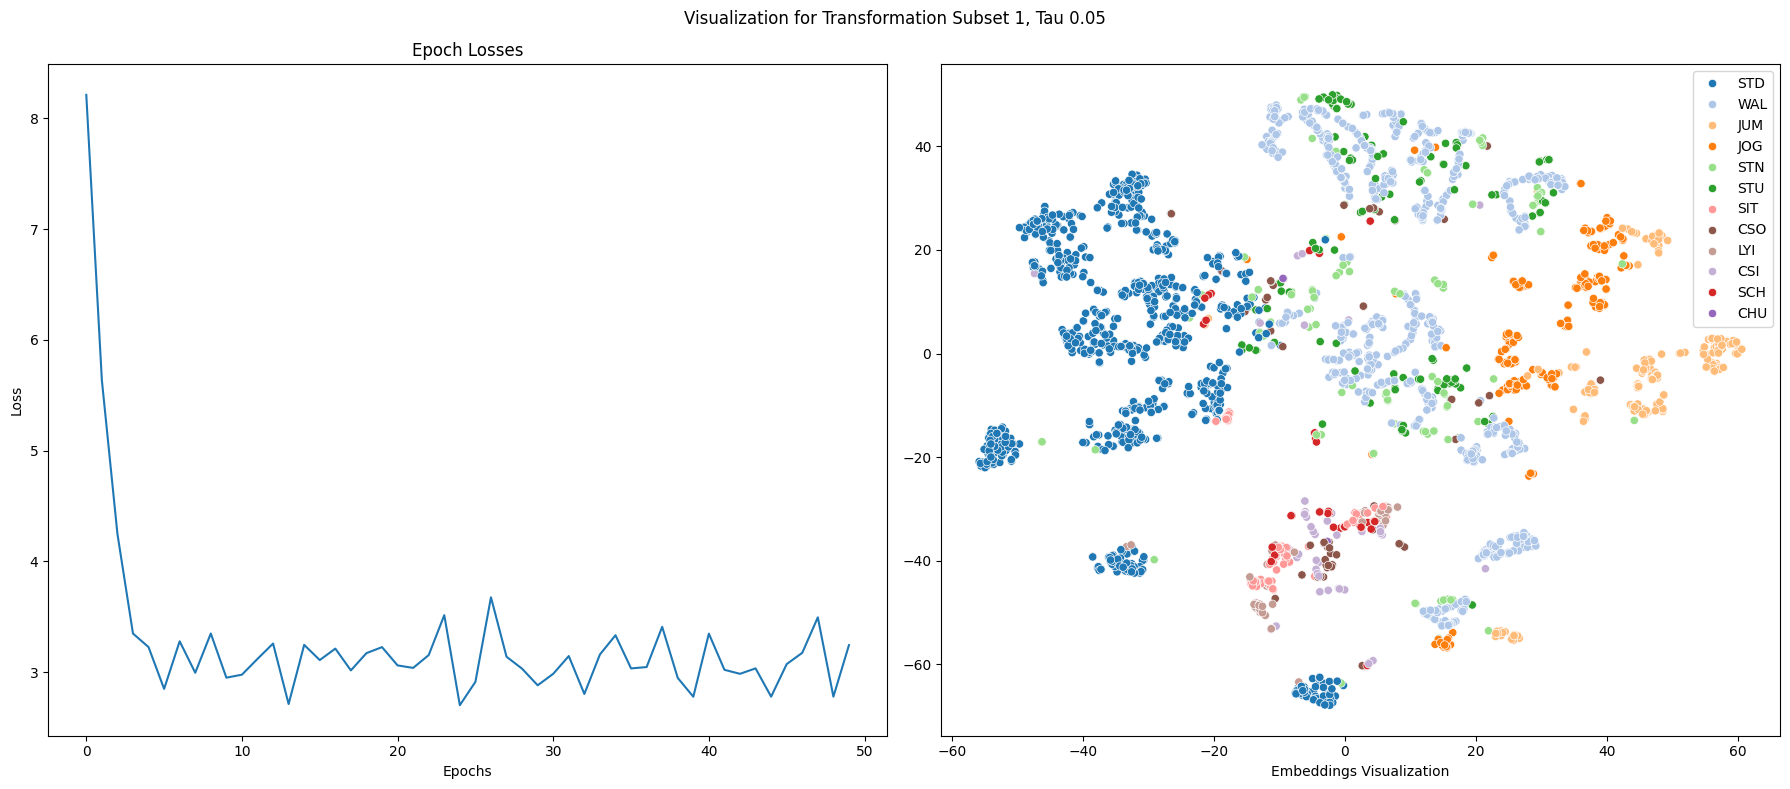

Completed training and visualization for transformation subset 1 and tau 0.05
Training model with transformations subset 2...
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2592 samples in 0.000s...
[t-SNE] Computed neighbors for 2592 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2592
[t-SNE] Computed conditional probabilities for sample 2000 / 2592
[t-SNE] Computed conditional probabilities for sample 2592 / 2592
[t-SNE] Mean sigma: 0.434227
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.406860
[t-SNE] KL divergence after 1000 iterations: 0.747418


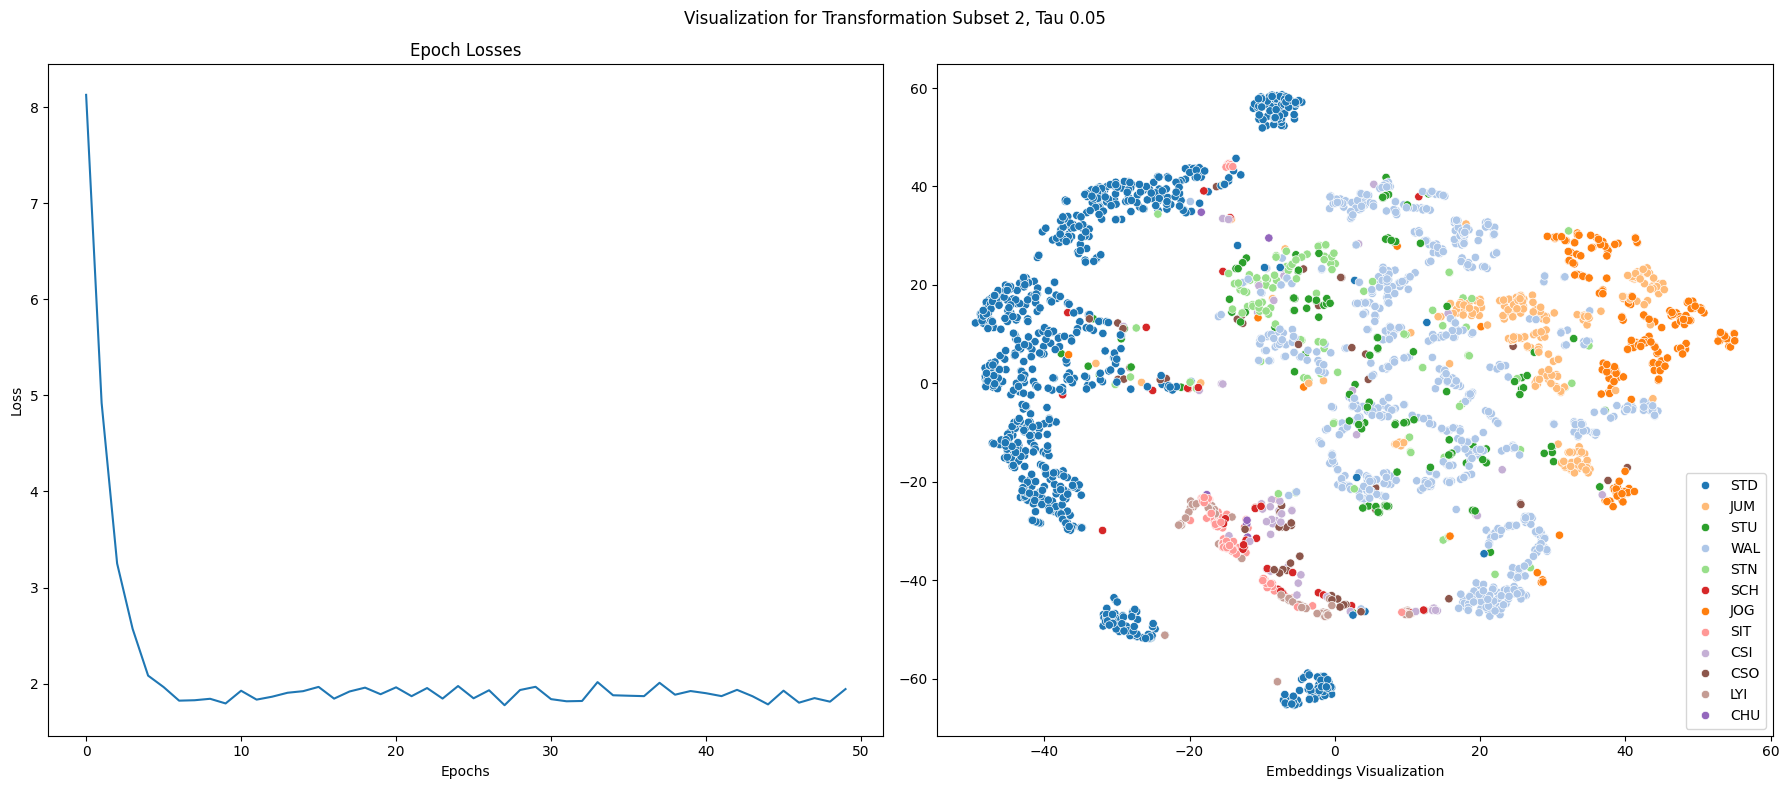

Completed training and visualization for transformation subset 2 and tau 0.05
Training model with transformations subset 3...
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2592 samples in 0.001s...
[t-SNE] Computed neighbors for 2592 samples in 0.037s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2592
[t-SNE] Computed conditional probabilities for sample 2000 / 2592
[t-SNE] Computed conditional probabilities for sample 2592 / 2592
[t-SNE] Mean sigma: 0.636686
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.507751
[t-SNE] KL divergence after 1000 iterations: 0.774432


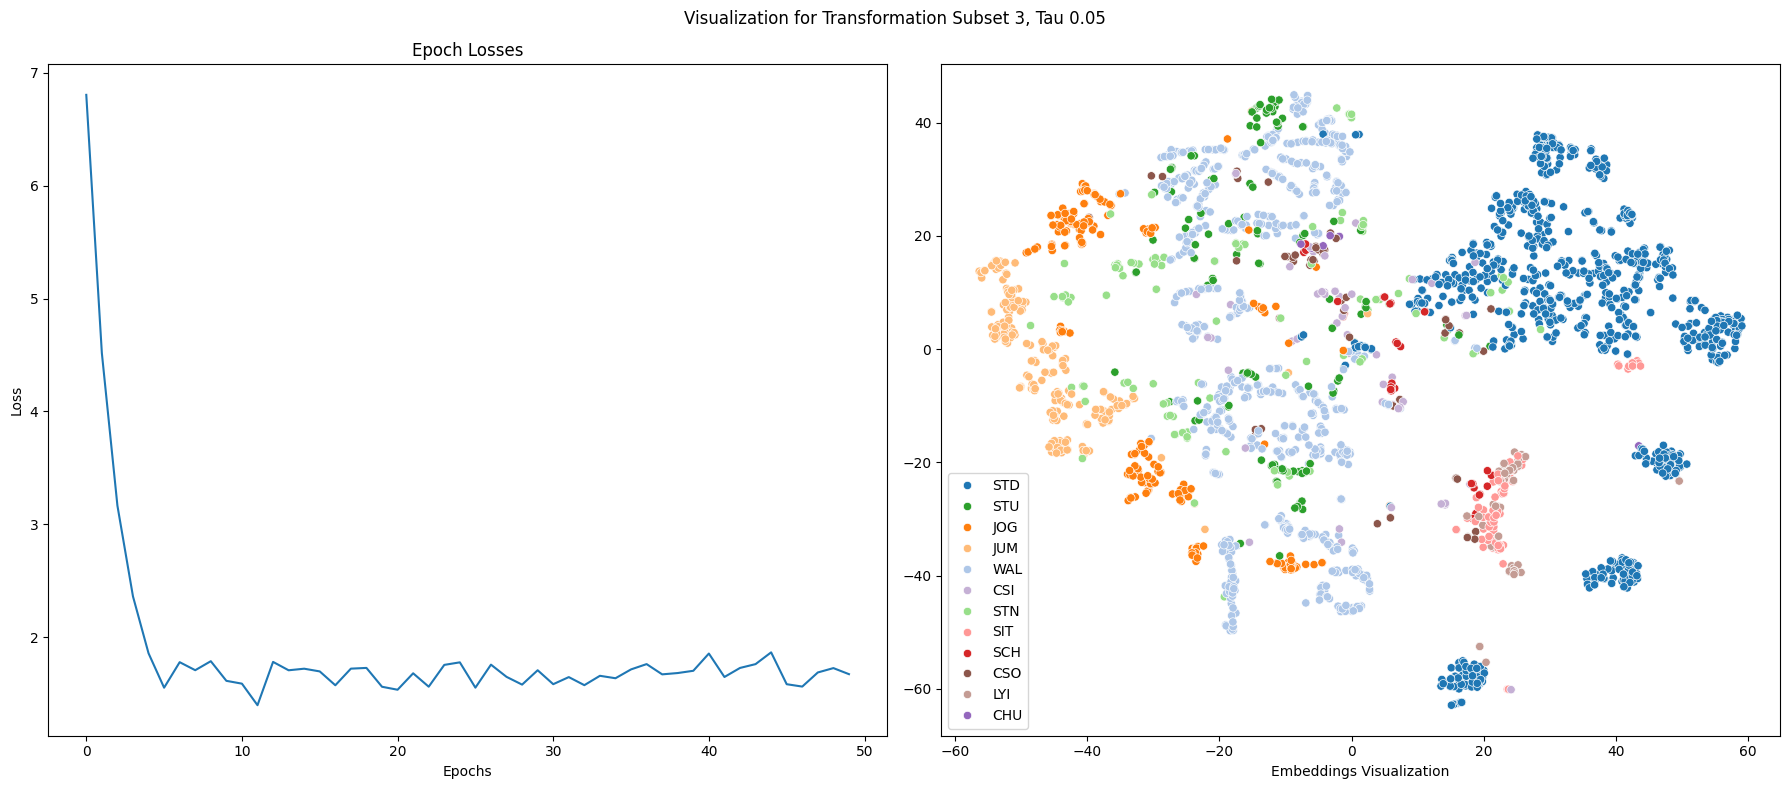

Completed training and visualization for transformation subset 3 and tau 0.05
Testing with tau (temperature) value: 0.2
Training model with transformations subset 1...
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2592 samples in 0.000s...
[t-SNE] Computed neighbors for 2592 samples in 0.037s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2592
[t-SNE] Computed conditional probabilities for sample 2000 / 2592
[t-SNE] Computed conditional probabilities for sample 2592 / 2592
[t-SNE] Mean sigma: 0.612861
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.541191
[t-SNE] KL divergence after 1000 iterations: 0.597251


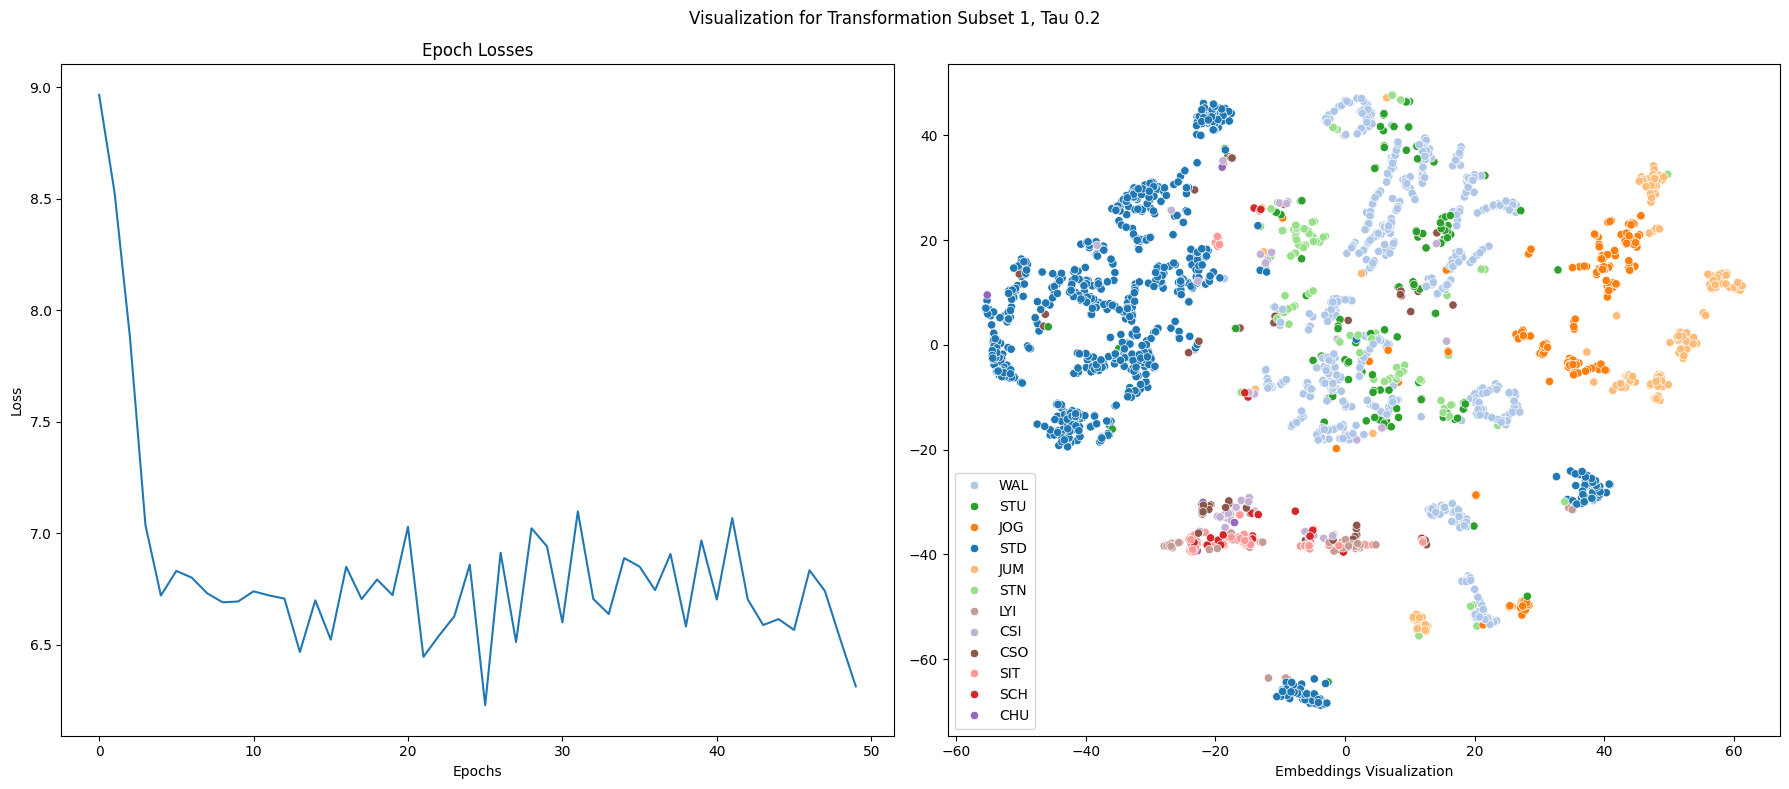

Completed training and visualization for transformation subset 1 and tau 0.2
Training model with transformations subset 2...
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2592 samples in 0.000s...
[t-SNE] Computed neighbors for 2592 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2592
[t-SNE] Computed conditional probabilities for sample 2000 / 2592
[t-SNE] Computed conditional probabilities for sample 2592 / 2592
[t-SNE] Mean sigma: 0.448382
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.336296
[t-SNE] KL divergence after 1000 iterations: 0.669300


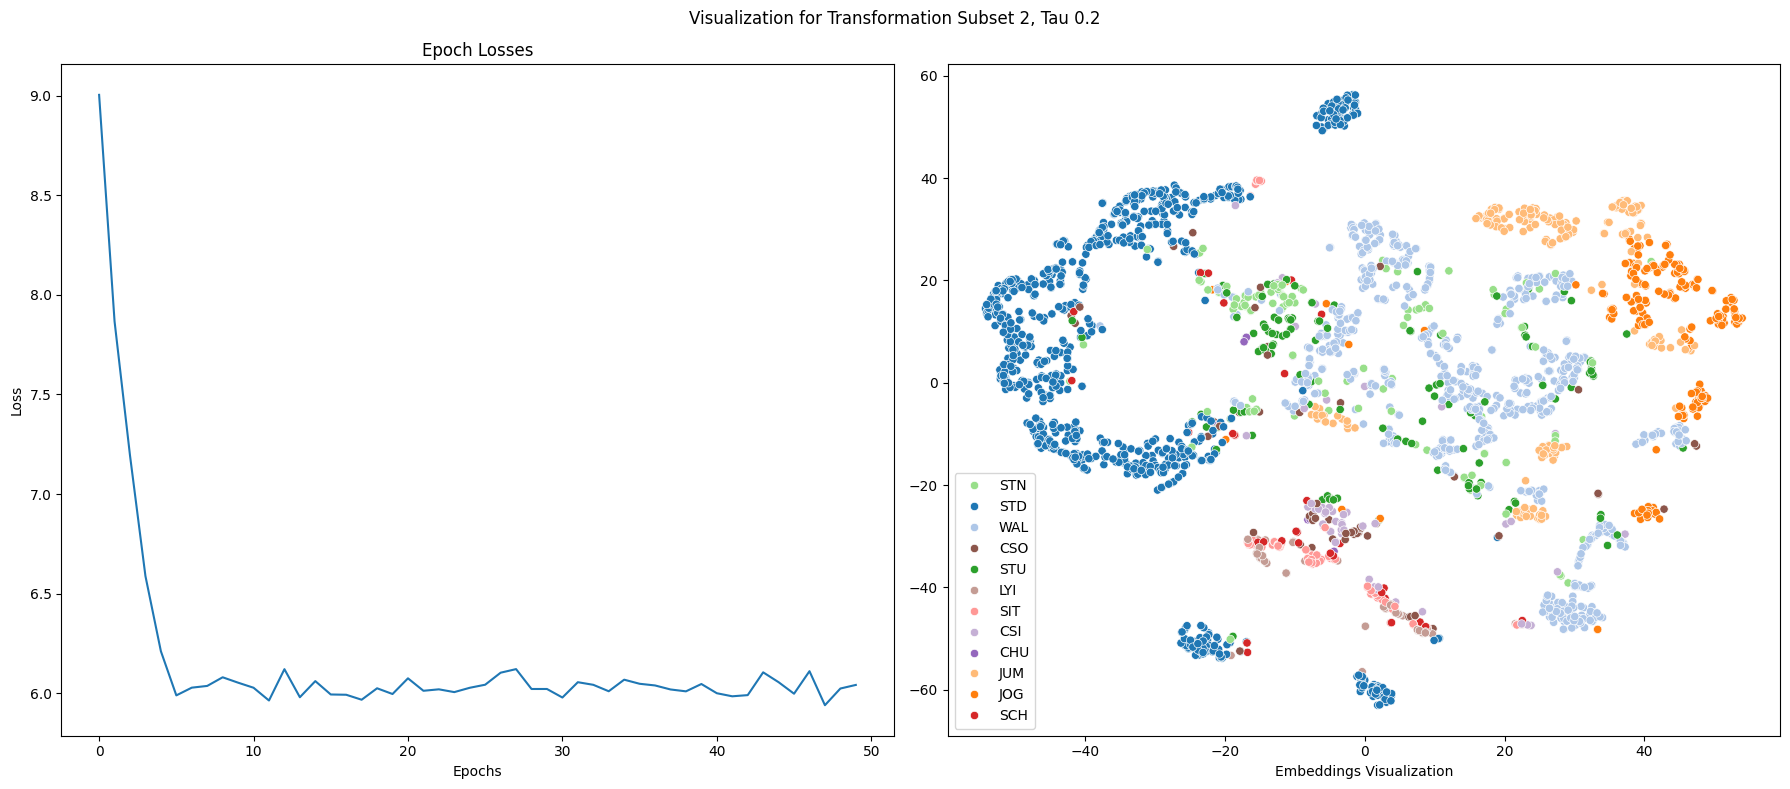

Completed training and visualization for transformation subset 2 and tau 0.2
Training model with transformations subset 3...
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2592 samples in 0.000s...
[t-SNE] Computed neighbors for 2592 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2592
[t-SNE] Computed conditional probabilities for sample 2000 / 2592
[t-SNE] Computed conditional probabilities for sample 2592 / 2592
[t-SNE] Mean sigma: 0.747401
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.122299
[t-SNE] KL divergence after 1000 iterations: 0.701526


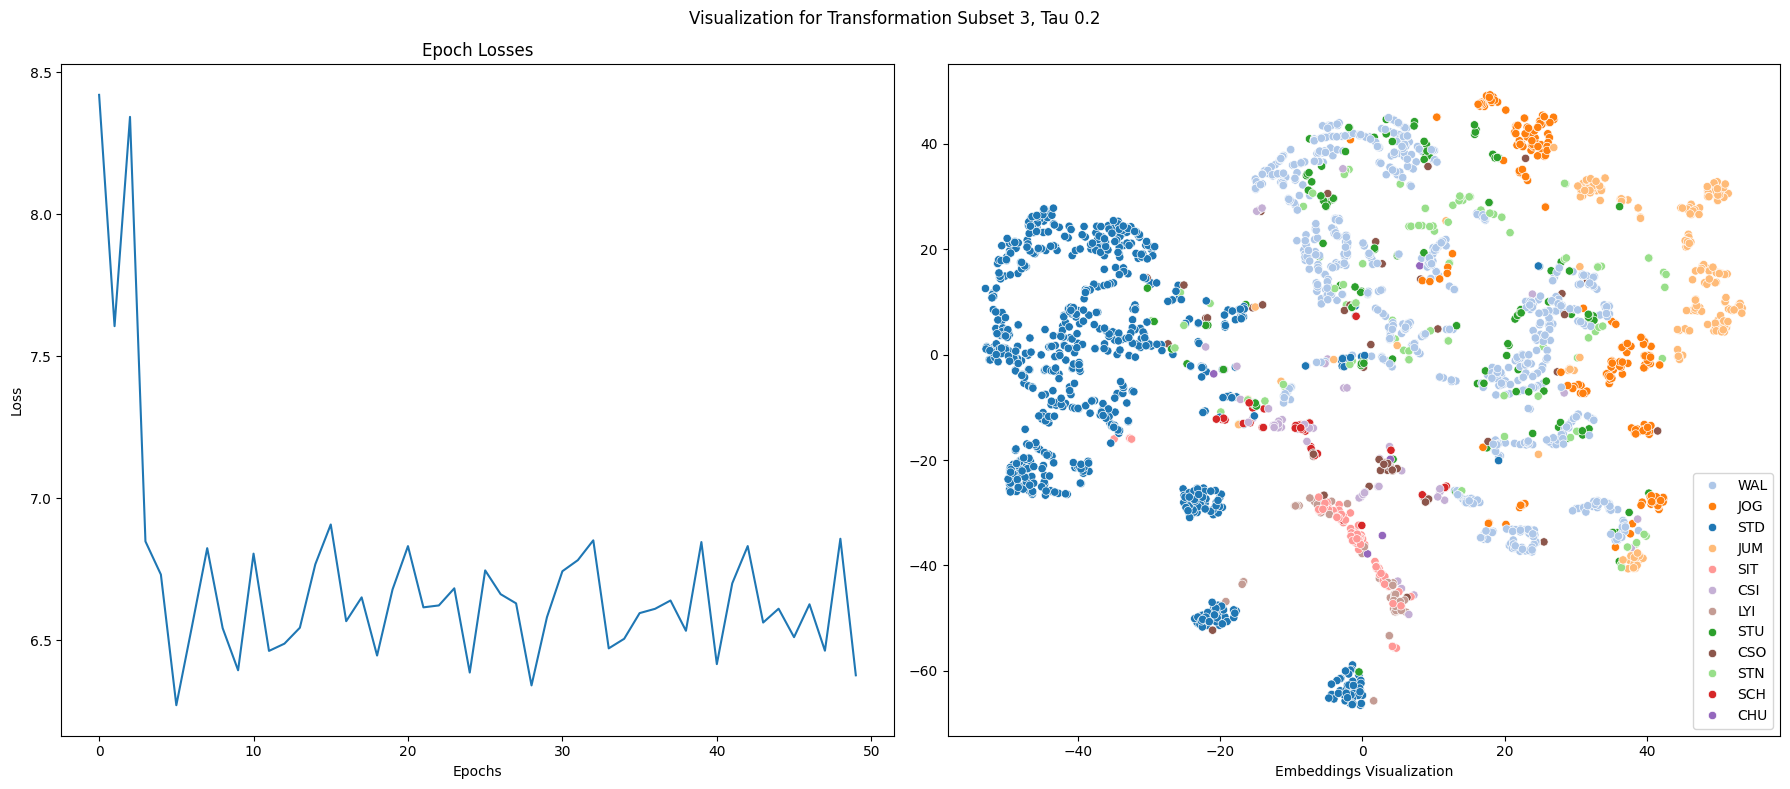

Completed training and visualization for transformation subset 3 and tau 0.2
Testing with tau (temperature) value: 1.0
Training model with transformations subset 1...
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2592 samples in 0.000s...
[t-SNE] Computed neighbors for 2592 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2592
[t-SNE] Computed conditional probabilities for sample 2000 / 2592
[t-SNE] Computed conditional probabilities for sample 2592 / 2592
[t-SNE] Mean sigma: 0.413881
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.005222
[t-SNE] KL divergence after 1000 iterations: 0.571603


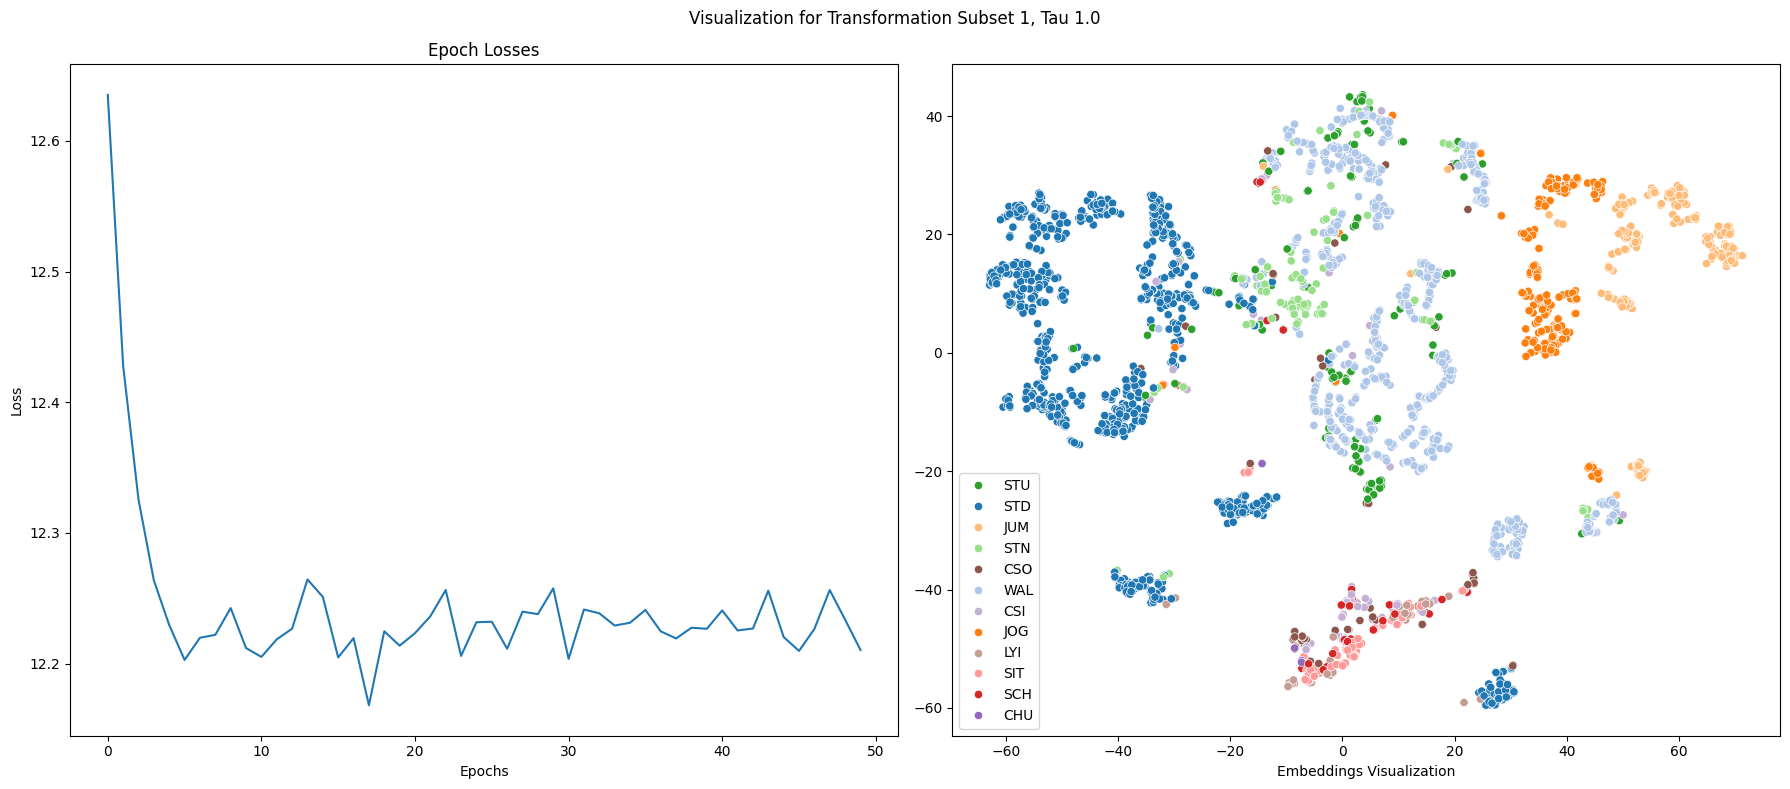

Completed training and visualization for transformation subset 1 and tau 1.0
Training model with transformations subset 2...
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2592 samples in 0.000s...
[t-SNE] Computed neighbors for 2592 samples in 0.037s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2592
[t-SNE] Computed conditional probabilities for sample 2000 / 2592
[t-SNE] Computed conditional probabilities for sample 2592 / 2592
[t-SNE] Mean sigma: 0.362972
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.741501
[t-SNE] KL divergence after 1000 iterations: 0.634065


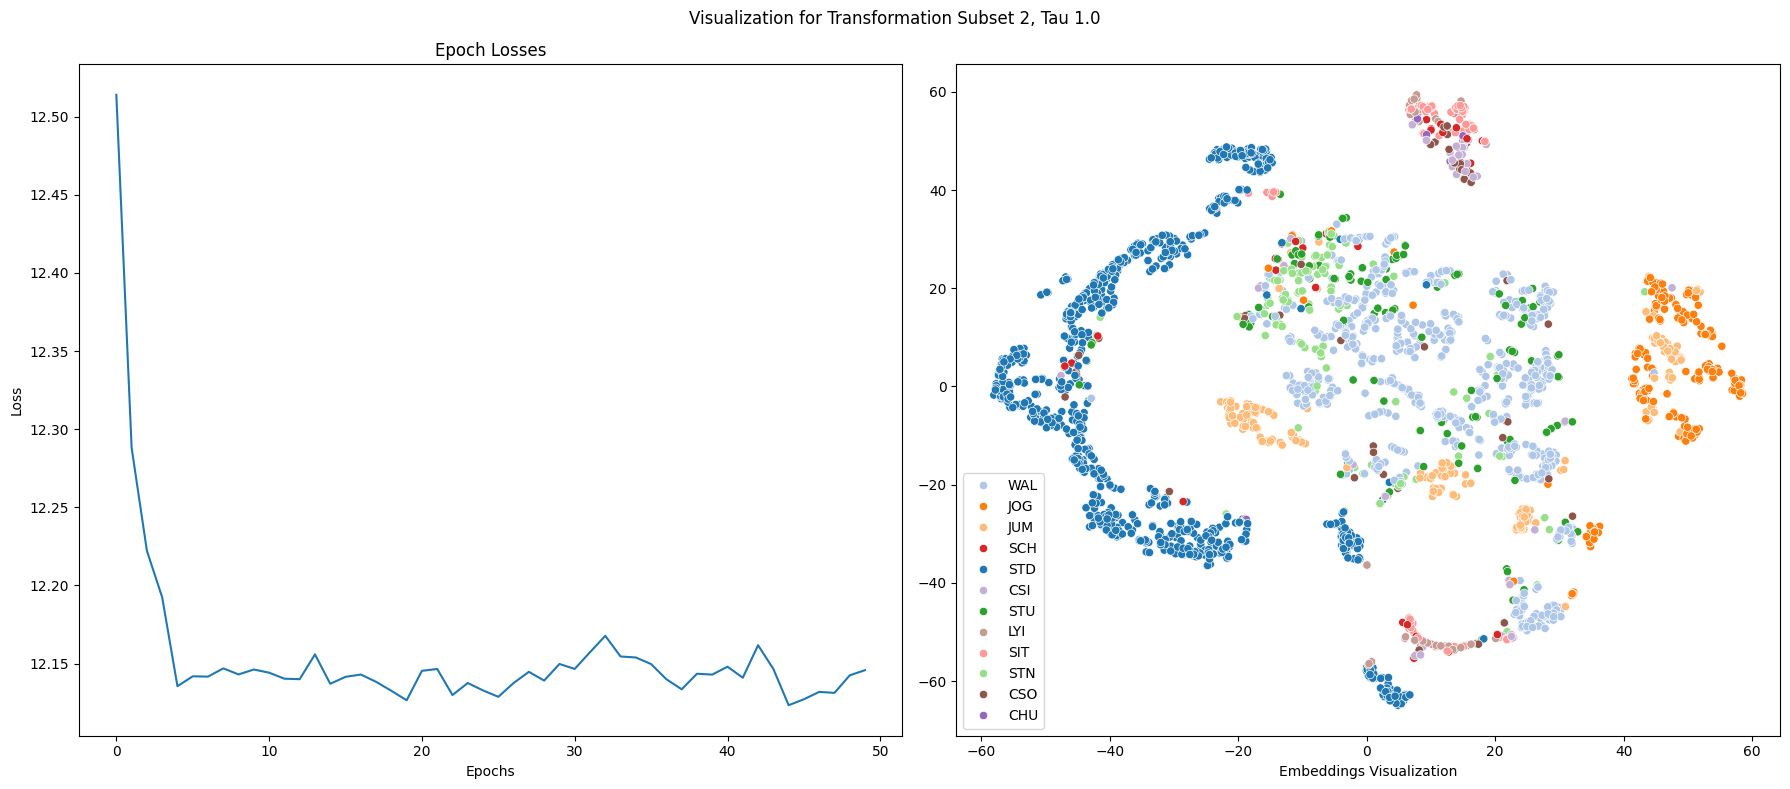

Completed training and visualization for transformation subset 2 and tau 1.0
Training model with transformations subset 3...
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2592 samples in 0.000s...
[t-SNE] Computed neighbors for 2592 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2592
[t-SNE] Computed conditional probabilities for sample 2000 / 2592
[t-SNE] Computed conditional probabilities for sample 2592 / 2592
[t-SNE] Mean sigma: 0.337732
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.414104
[t-SNE] KL divergence after 1000 iterations: 0.621545


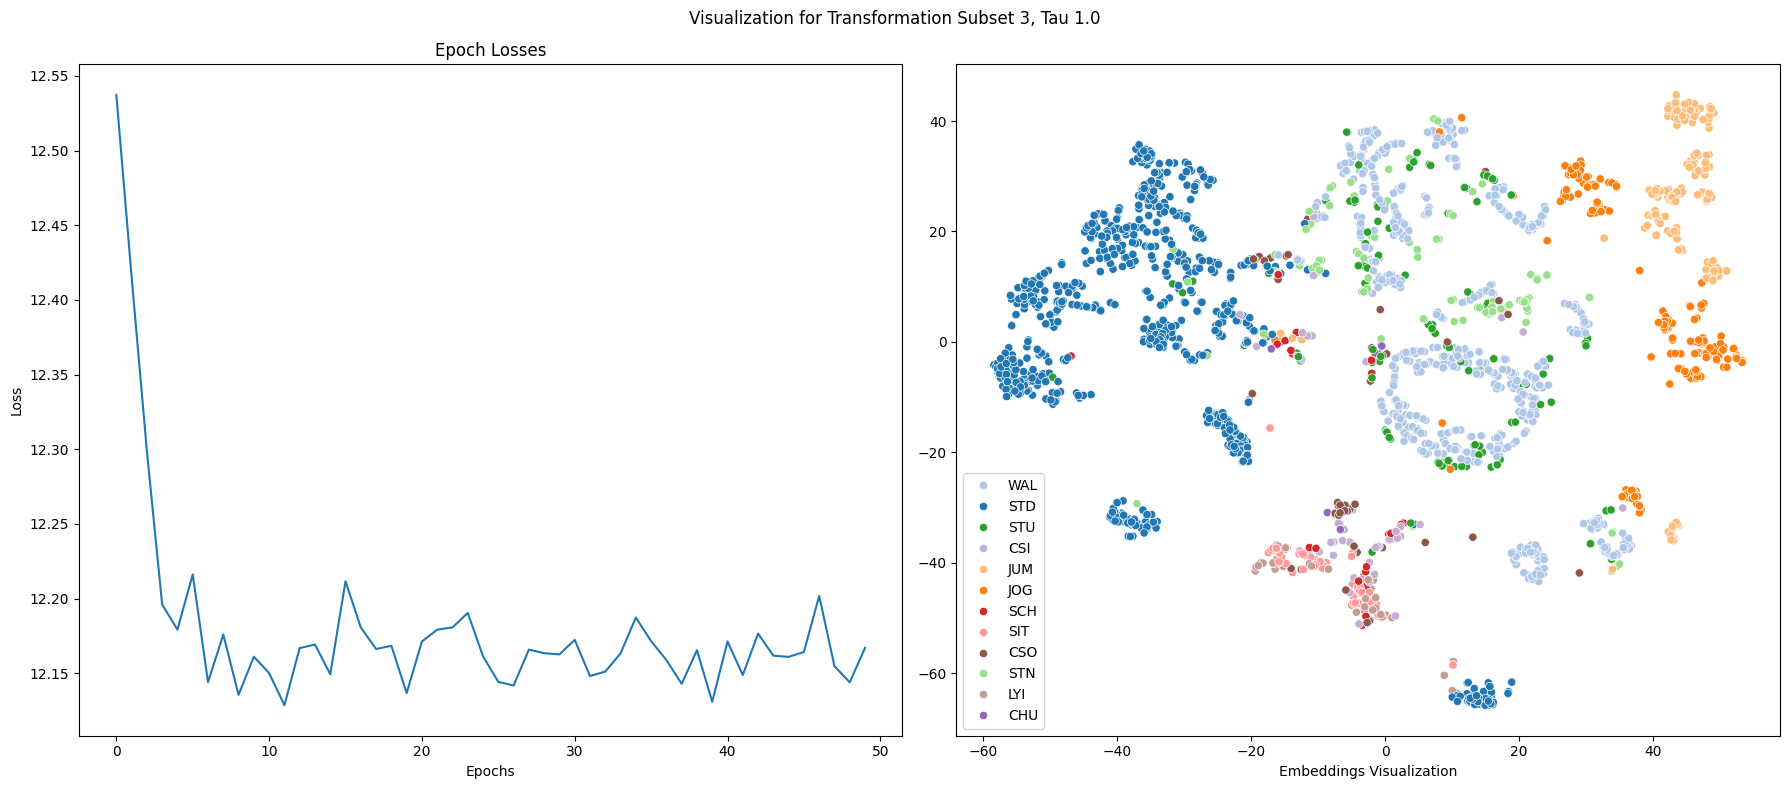

Completed training and visualization for transformation subset 3 and tau 1.0
All Pre-training and visualization completed


In [65]:
# subsets of transformations to apply to the data
transformations_subsets = [
    [add_gaussian_noise, scale_data, rotation_transform, invert_data, reverse_data, random_permutation, stretching_warping, shuffle_channels], # all transformations
    [random_permutation, shuffle_channels], # transformations proposed in paper [1]
    [add_gaussian_noise, scale_data, rotation_transform] # transformations proposed in paper [3]
]
tau_values = [0.05, 0.2, 1.0] # tau indicates the temperature value used in the loss function

# hyperparameters
batch_size = 512
epochs = 50
decay_steps = 1000   # hyperparameter of the loss function used in the original paper

unique_labels = list(REVERSED_LABELS_DICT.values())
color_palette = plt.cm.tab20(range(len(unique_labels))) # color palette for the scatter plot
label_to_color = {label: color_palette[i] for i, label in enumerate(unique_labels)}

# loop over the temperature values
for tau in tau_values: 
    print(f"Testing with tau (temperature) value: {tau}")
    
    # loop over the subsets of transformations
    for i,transformations in enumerate(transformations_subsets, 1):
        print(f"Training model with transformations subset {i}...")
        
        transformer_enc = create_transformer_encoder(input_shape)
        pretraining_model = attach_projection_head(transformer_enc)

        lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.1, decay_steps=decay_steps)
        optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

        trained_simclr_model, epoch_losses = simclr_train_model(pretraining_model,
                                                            pre_train_data,
                                                            pre_train_labels,
                                                            optimizer,
                                                            batch_size,
                                                            apply_random_transformations,
                                                            transformations,
                                                            class_weights=class_weights_tensor, # class_weights are used in the loss function
                                                            temperature=tau,
                                                            epochs=epochs,
                                                            verbose=0)

        # Extract the output of the transformer encoder 
        transformer_output = trained_simclr_model.get_layer('global_max_pooling1d').output
        # Create a new model from the input to this output
        trained_transformer_enc = Model(inputs=trained_simclr_model.input, outputs=transformer_output)

        # Save the entire model
        trained_transformer_enc.save(models_path + f"\\pretrained_transformer_sub{i}_tau{tau}.keras")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
        fig.suptitle(f"Visualization for Transformation Subset {i}, Tau {tau}")
        
        ax1.plot(epoch_losses)
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title(f"Epoch Losses")
        
        test_data_subset, _, test_labels_subset, _ = train_test_split(test_data, test_labels, test_size=0.90, stratify=test_labels)
        
        intermediate_model = Model(inputs=trained_transformer_enc.inputs, outputs=trained_transformer_enc.get_layer("global_max_pooling1d").output)
        embeddings = intermediate_model.predict(test_data_subset)
        
        features_reduced = TSNE(perplexity=30, verbose=1, random_state=42).fit_transform(embeddings)
        
        mapped_labels = [REVERSED_LABELS_DICT[lab] for lab in test_labels_subset]
        sns.scatterplot(x=features_reduced[:,0], y=features_reduced[:,1], hue=mapped_labels, palette=label_to_color, ax=ax2)
        ax2.set_xlabel("Embeddings Visualization")
        plt.tight_layout()
        plt.show()
        
        print(f"Completed training and visualization for transformation subset {i} and tau {tau}")

print("All Pre-training and visualization completed")    

## Finetuning

During the finetuning phase, the pre-trained transformer-encoder will be attached to the prediction head and trained on a small subset of data in a supervised manner.

The training setup for finetuning will account for the trainability of the pre-trained layers and also for the possibility of piecewise training of the model. This setup will set a lower learning rate for the pre-trained layers, exploiting the weights learned during pretraining while also allowing for their finetuning.

In [25]:
def training_setup(model_name,  lr = 0.001, trainable = False, piece_wise = False ):

    #load the weights of the trained transformer encoder
    transformer_enc= load_model(models_path + model_name)

    if trainable:
        for layer in transformer_enc.layers:
            layer.trainable = True
    else:
        # Freeze the transformer encoder layers
        for layer in transformer_enc.layers:
            layer.trainable = False

    fine_tuning_model = attach_prediction_head(transformer_enc, num_classes=len(classes))
    fine_tuning_model2 = attach_prediction_head_v2(transformer_enc, num_classes=len(classes))

    # PiecewiseConstantDecay is a custom learning rate used to define different learning rates for the different layers
    if piece_wise:
        #Define different learning rates for the pre-trained layers and the new layers
        pretrain_layers_lr = lr / 10 
        new_layers_lr = lr 

        # PiecewiseConstantDecay learning rate scheduler
        lr_schedule = PiecewiseConstantDecay(boundaries=[len(transformer_enc.layers)],
                                            values=[new_layers_lr, pretrain_layers_lr])
        fine_tuning_model.compile(optimizer=Adam(learning_rate=lr_schedule), loss="categorical_crossentropy", metrics=["accuracy"])
        fine_tuning_model2.compile(optimizer=Adam(learning_rate=lr_schedule), loss="categorical_crossentropy", metrics=["accuracy"])      
    else:
        fine_tuning_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
        fine_tuning_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
        
    return fine_tuning_model, fine_tuning_model2

Summary of the two implementations of the fine-tune models

In [85]:
model_name = r"\pretrained_transformer_sub1_tau0.05.keras"
fine_tuning_model1, fine_tuning_model2 = training_setup(model_name, lr = 0.001, trainable = True, piece_wise = False)
print(fine_tuning_model1.summary())
print(fine_tuning_model2.summary())

c:\Users\Riccardo Adorante\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "prediction_head"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 30, 6)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 23, 32)    │      1,568 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 23, 32)    │        128 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_16      │ (None, 23, 32)    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 23, 32)    │          0 │ leaky_re_lu_16[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 20, 64)    │      8,256 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 64)    │        256 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_17      │ (None, 20, 64)    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 20, 64)    │          0 │ leaky_re_lu_17[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 18, 96)    │     18,528 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 18, 96)    │        384 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_18      │ (None, 18, 96)    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 18, 96)    │          0 │ leaky_re_lu_18[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 18, 96)    │     37,248 │ dropout_32[0][0], │
│ (MultiHeadAttentio… │                   │            │ dropout_32[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 18, 96)    │          0 │ dropout_32[0][0], │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 18, 96)    │        192 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 96)        │          0 │ layer_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_15          │ (None, 96)        │          0 │ global_max_pooli… │
│ (Flatten)           │                   │            │                 

 Total params: 125,836 (491.55 KB)

 Trainable params: 125,452 (490.05 KB)

 Non-trainable params: 384 (1.50 KB)

None


Model: "prediction_head_v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 30, 6)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 23, 32)    │      1,568 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 23, 32)    │        128 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_16      │ (None, 23, 32)    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 23, 32)    │          0 │ leaky_re_lu_16[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 20, 64)    │      8,256 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 64)    │        256 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_17      │ (None, 20, 64)    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 20, 64)    │          0 │ leaky_re_lu_17[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 18, 96)    │     18,528 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 18, 96)    │        384 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_18      │ (None, 18, 96)    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 18, 96)    │          0 │ leaky_re_lu_18[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 18, 96)    │     37,248 │ dropout_32[0][0], │
│ (MultiHeadAttentio… │                   │            │ dropout_32[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 18, 96)    │          0 │ dropout_32[0][0], │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 18, 96)    │        192 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 96)        │          0 │ layer_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 1, 96)     │          0 │ global_max_pooli… │
│ (Reshape)           │                   │            │                 

 Total params: 568,076 (2.17 MB)

 Trainable params: 565,132 (2.16 MB)

 Non-trainable params: 2,944 (11.50 KB)

None


To find the best model, all 9 models were evaluated after finetuning. The models trained with a tau equal to 0.2 and 1.0 heavily underperformed, likely due to the high loss introduced by such temperatures during pre-training.

When evaluating the models with tau = 0.05, the one pre-trained using the complete spectrum of transformations performed the best in every finetuning setting.

For this reason, only the pre-trained model "pretrained_transformer_sub1_tau0.05.keras" is used for result visualization after the finetuning phase.

During finetuning, 3 cases can be analyzed:

1. **Trainable = False, Piecewise = False**: Only the new layers will be trainable with lr = 0.001.
2. **Trainable = True, Piecewise = True**: All layers will be trainable under the PiecewiseConstantDecay.
3. **Trainable = True, Piecewise = False**: All layers will be trainable with lr = 0.001.

Only in case 2 does the first implementation of the prediction head perform better. In all other cases, the second implementation outperforms by a considerable margin.

Training case 3 produced the best performing models. At the end of the finetuning process, the two confusion matrices of the two differently implemented prediction heads can be viewed.

(2151, 30, 6) (240, 30, 6) (2151,) (240,) 2151 240
{0: 0.25865800865800864, 1: 0.2774767801857585, 2: 0.9484126984126984, 3: 0.9958333333333333, 4: 1.8290816326530612, 5: 1.9697802197802199, 6: 6.181034482758621, 7: 2.1088235294117648, 8: 29.875, 9: 3.8138297872340425, 10: 3.9833333333333334, 11: 4.267857142857143}
Creating the model...

Training...
Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2189 - loss: 2.6468 - val_accuracy: 0.5292 - val_loss: 1.5106
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5170 - loss: 1.8363 - val_accuracy: 0.6417 - val_loss: 1.2008
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5776 - loss: 1.5747 - val_accuracy: 0.6792 - val_loss: 1.0946
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6244 - loss: 1.3669 - val_accuracy: 0.7000 - val_loss: 1.0039
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6145 - loss: 1.3619 - val_accuracy: 0.7333 - val_loss: 0.8436
Epoch 6/200

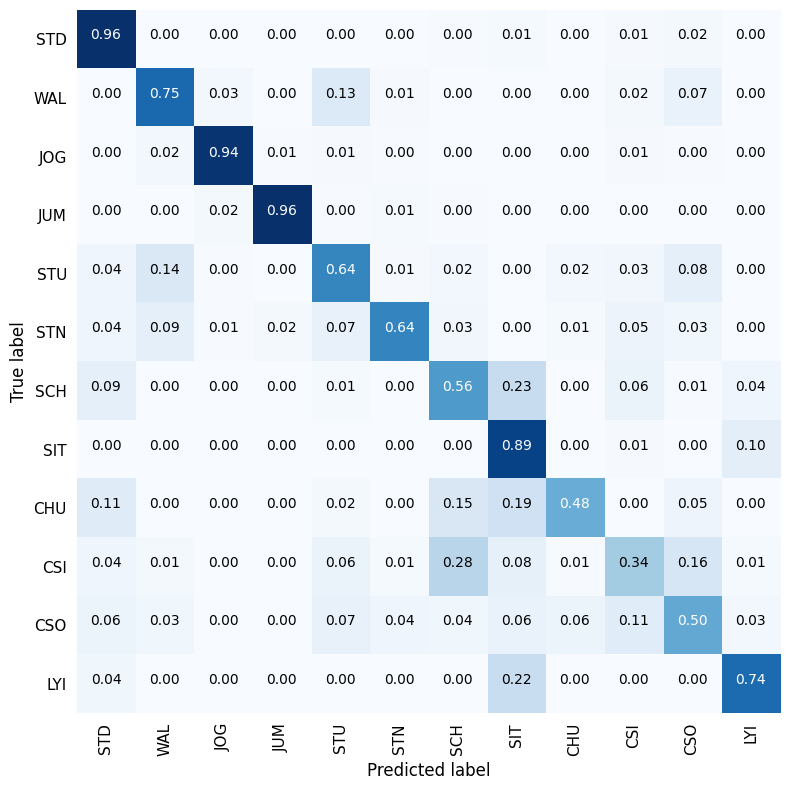

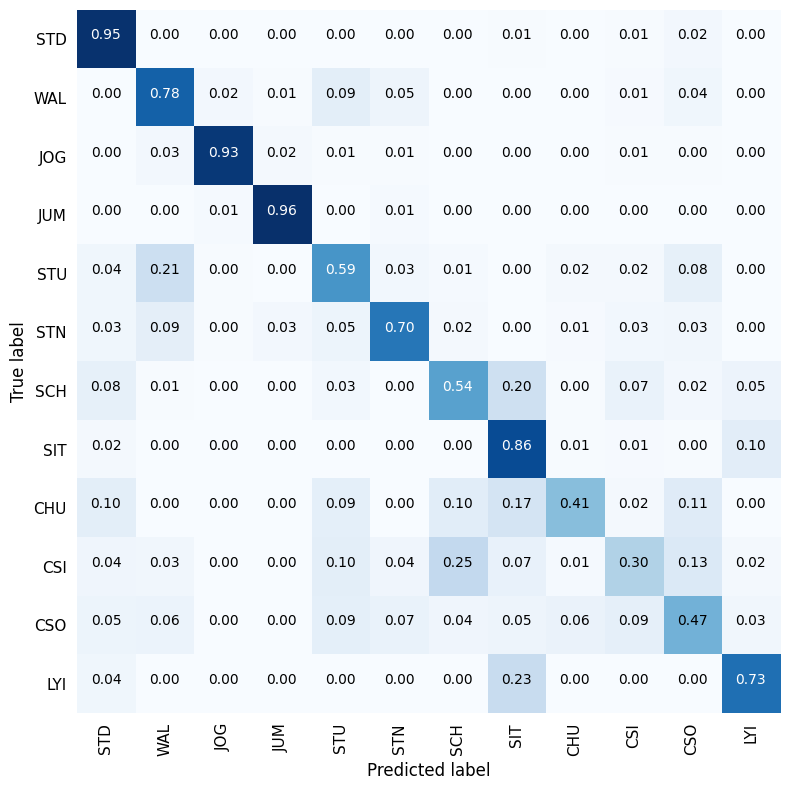

In [86]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

cm = [np.zeros([len(classes)]) for _ in range(len(classes))]

n_epochs = 200
batch_size = 128

ohe_labels_fine_tuning = np.array(ohe_labels_fine_tuning)
ohe_test_labels = np.array(ohe_test_labels)

# create validation data as a subset of the fine-tuning data

fine_tune_data, fine_tune_val_data, fine_tune_labels, fine_tune_val_labels, ohe_fine_labels, ohe_val_fine_labels = train_test_split(fine_tuning_data, fine_tuning_labels, ohe_labels_fine_tuning, test_size=0.1)
print(fine_tune_data.shape, fine_tune_val_data.shape, fine_tune_labels.shape, fine_tune_val_labels.shape, len(ohe_fine_labels), len(ohe_val_fine_labels))


class_weights_finetune = compute_class_weight('balanced', classes=np.unique(fine_tune_labels), y=fine_tune_labels)
class_weights_dict_finetune = dict(enumerate(class_weights_finetune))
print(class_weights_dict_finetune)

print("Creating the model...")
for fine_tuning_model in [fine_tuning_model1, fine_tuning_model2]:
    print("\nTraining...")
    history = fine_tuning_model.fit(x=fine_tune_data,
                    y=ohe_fine_labels,
                    batch_size = batch_size,
                    epochs = n_epochs,
                    validation_data = (fine_tune_val_data, ohe_val_fine_labels),
                    class_weight=class_weights_dict_finetune,
                    callbacks=[early_stopping])

    print("\nPredicting...")
    y_preds = fine_tuning_model.predict(test_data)
    y_preds = np.argmax(y_preds, axis=1)
    y_targets = np.argmax(ohe_test_labels, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))

    print("\nConfusion Matrix:")
    s_preds, s_targets = [], []
    for el in y_preds: s_preds.append(classes[el])
    for el in y_targets: s_targets.append(classes[el])

    cm += confusion_matrix(s_targets, s_preds, labels=classes)
    cm = cm.astype(np.int32)

    plot_confusion_matrix(cm, classes)